#Analyses

1.   Comparison groups

WP vs. ctr
All case vs ctr
WP vs PP
PP vs ctr

2.  Analyses
- DEG + gene sets (gsea Gorilla..)
- Unsupervised:
  - Take highly varible genes (saytop 1000) and do PCA and UMAP
  Do the WP separate from ctr/PP/other cases (medium pred)
  - Clustering - can also do on highly var genes - do WP separate? PP?
  Distance metric: cosine, correlation, zscore then euclidean

  Overall, we observed a significant decrease in ELAVL3, PFKP, RCAN1, SELPLG, and STMN2 mRNA expression (Figures 1-2, Supplemental Figure 1, Supplemental File 1) and a significant increase in cryptic exon containing ACTL6B, ARHGAP32, CAMK2B, CDK7, DNM1, HDGFL2, MYO18A, SYT7, and truncated STMN2 mRNA expression at day 46 and 60, but not day 32 of differentiation (Figures 3-4, Supplemental Figure 2, Supplemental File 1). The expression of ACTIN and POM121 remain unchanged. Interestingly, we were unable to detect changes in UNC13A (Figures 1-2, Supplemental Figure 1, Supplemental File 1) and cryptic exon containing NUP188, POLDIP3, and UNC13A (Figures 3-4, Supplemental Figure 2, Supplemental File 1) mRNA expression at the time points evaluated.



In [1]:
from google.colab import drive

# This will prompt you to authenticate and authorize Colab to access your Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load sample accuracies
import pandas as pd
import numpy as np

caseAccuracies__logisticRegression = pd.read_csv('../src/projects/NUPs60-aals-rsID-rareBinned-0.0025MAF/LogisticRegression/excessResults_LogisticRegression_NUPs60-aals-rsID-rareBinned-0.0025MAF.csv')
controlAccuracies__logisticRegression = pd.read_csv('../src/projects/NUPs60->=85%accurateCasesLR-aals-rsID-rareBinned-0.0025MAF/LogisticRegression/excessResults_LogisticRegression_NUPs60->=85%accurateCasesLR-aals-rsID-rareBinned-0.0025MAF.csv')
controlAccuracies__logisticRegression = controlAccuracies__logisticRegression[controlAccuracies__logisticRegression['label'] == 0]

# Assuming the dataframe is named caseAccuracies__logisticRegression
# Assuming the dataframe is named controlAccuracies__logisticRegression

# Select well-predicted (>=85% mean accuracy)
well_predicted_cases = caseAccuracies__logisticRegression[caseAccuracies__logisticRegression['accuracy_mean'] >= 0.85]
well_predicted_controls = controlAccuracies__logisticRegression[controlAccuracies__logisticRegression['accuracy_mean'] >= 0.85]

# Select poorly-predicted (<=15% mean accuracy)
poorly_predicted_cases = caseAccuracies__logisticRegression[caseAccuracies__logisticRegression['accuracy_mean'] <= 0.15]
poorly_predicted_controls = controlAccuracies__logisticRegression[controlAccuracies__logisticRegression['accuracy_mean'] <= 0.15]

# Print the results
print("Well-predicted cases (>=85% mean accuracy):")
print(well_predicted_cases)
print(f"\nNumber of well-predicted cases: {len(well_predicted_cases)}")

print("Well-predicted controls (>=85% mean accuracy):")
print(well_predicted_controls)
print(f"\nNumber of well-predicted controls: {len(well_predicted_controls)}")

print("\nPoorly-predicted cases (<=15% mean accuracy):")
print(poorly_predicted_cases)
print(f"\nNumber of poorly-predicted cases: {len(poorly_predicted_cases)}")

print("\nPoorly-predicted controls (<=15% mean accuracy):")
print(poorly_predicted_controls)
print(f"\nNumber of poorly-predicted controls: {len(poorly_predicted_controls)}")


Well-predicted cases (>=85% mean accuracy):
                                         id  probability_mean  \
1           ALS__CGND-HDA-00004__UP-WGS-187          0.553757   
3           ALS__CGND-HDA-00012__UP-WGS-195          0.537712   
6           ALS__CGND-HDA-00018__UP-WGS-201          0.542392   
28          ALS__CGND-HDA-00084__UP-WGS-268          0.542325   
29          ALS__CGND-HDA-00086__UP-WGS-270          0.536317   
...                                     ...               ...   
2047  aals-ALS__CGND-HDA-04064__NEUKW840TXJ          0.535504   
2050  aals-ALS__CGND-HDA-04067__NEUJA207UUV          0.529001   
2051  aals-ALS__CGND-HDA-04068__NEUAX021NPV          0.548921   
2058  aals-ALS__CGND-HDA-04076__NEUDZ810BCM          0.534631   
2069  aals-ALS__CGND-HDA-04089__NEUEU419NMF          0.547211   

      probability_std  prediction_most_frequent  label  accuracy_mean  \
1            0.052516                         1      1       0.958537   
3            0.041233        

In [51]:
import pandas as pd
nupsVariants = pd.read_excel('../adhoc analysis/Variant_report_NUPs_fixed_2022-03-28.xlsx', sheet_name="all cases vs all controls")
clinical_data = pd.read_excel('../adhoc analysis/ALS Consortium WGS Metadata 03112022.xlsx')

In [5]:
nupsGeneList = nupsVariants['Gene'].dropna().unique()

In [6]:
nupsGeneList.shape

(61,)

In [9]:
%pip install biomart
from biomart import BiomartServer
from tqdm.notebook import tqdm

# Connect to Ensembl BioMart
server = BiomartServer("http://www.ensembl.org/biomart")
dataset = server.datasets["hsapiens_gene_ensembl"]

# Get the mapping including synonyms
attributes = ['ensembl_gene_id', 'external_gene_name', 'gene_biotype', 'external_synonym']
response = dataset.search({
    'attributes': attributes
})

# Create a dictionary for mapping
id_map = {}
synonym_map = {}
for line in tqdm(response.iter_lines()):
    line = line.decode('utf-8').split('\t')
    ensembl_id, symbol, biotype, synonym = line

    if ensembl_id not in id_map:
        id_map[ensembl_id] = {'symbol': symbol, 'biotype': biotype, 'synonyms': set()}

    if synonym:
        id_map[ensembl_id]['synonyms'].add(synonym)
        synonym_map[synonym] = ensembl_id

    # Add the main symbol to synonyms as well
    if symbol:
        id_map[ensembl_id]['synonyms'].add(symbol)
        synonym_map[symbol] = ensembl_id

Note: you may need to restart the kernel to use updated packages.


0it [00:00, ?it/s]

In [10]:
# Convert the id_map to a DataFrame for easier lookup
nups_map = []
for ensembl_id, details in id_map.items():
    symbols = [details['symbol']] #+ list(details['synonyms'])
    for nupsGene in nupsGeneList:
      if nupsGene in symbols:
          nups_map.append({'ensembl_id': ensembl_id, 'symbol': nupsGene})

nups_map_df = pd.DataFrame(nups_map)

In [11]:
nups_map_df[nups_map_df.duplicated(['symbol'], keep=False)]

,ensembl_id,symbol
5,ENSG00000285302,CHMP4A
6,ENSG00000254505,CHMP4A
35,ENSG00000291836,AAAS
60,ENSG00000094914,AAAS


In [12]:
caseAccuracies__logisticRegression

,id,probability_mean,probability_std,prediction_most_frequent,label,accuracy_mean,accuracy_std,draw_count
0,ALS__CGND-HDA-00001__UP-WGS-185,0.493938,0.031463,0,1,0.279487,0.449324,390
1,ALS__CGND-HDA-00004__UP-WGS-187,0.553757,0.052516,1,1,0.958537,0.199603,410
2,ALS__CGND-HDA-00008__UP-WGS-191,0.480318,0.052267,0,1,0.426829,0.495221,410
3,ALS__CGND-HDA-00012__UP-WGS-195,0.537712,0.041233,1,1,0.943902,0.230391,410
4,ALS__CGND-HDA-00013__UP-WGS-196,0.526367,0.043332,1,1,0.754054,0.431230,370
...,...,...,...,...,...,...,...,...
2065,aals-ALS__CGND-HDA-04083__NEURN392PGA,0.507060,0.042875,0,1,0.405405,0.491635,370
2066,aals-ALS__CGND-HDA-04084__NEUHZ364FZW,0.489091,0.036707,0,1,0.348485,0.477214,330
2067,aals-ALS__CGND-HDA-04085__NEUXZ486GG5,0.475992,0.050857,0,1,0.461538,0.499159,390
2068,aals-ALS__CGND-HDA-04086__NEUDH813DE6,0.461434,0.043055,0,1,0.073529,0.261388,340


In [94]:
# load RNA counts matrix
rnaMatrix = pd.read_csv('../transcriptomics/4_matrix/AnswerALS-651-T-v1-release6_raw-counts.csv')
geneIDs = rnaMatrix['Geneid'].tolist()
rnaMatrix = rnaMatrix.set_index('Geneid')
rnaMatrix = rnaMatrix.drop(columns=['Unnamed: 0'])

# get only sample cols
sampleCols = [col for col in rnaMatrix.columns if '-' in col]
uniqueMask_sampleCols = pd.Series([
    col.split('-')[1] for col in sampleCols
    ]).duplicated(keep='first')
deduped_sampleIndices = np.where(uniqueMask_sampleCols==False)

# Deduplicate the sample columns
sampleCols = [sampleCols[i] for i in deduped_sampleIndices[0]]

# Log-normalize the numerical columns
# rnaMatrix[sampleCols] = np.log1p(rnaMatrix.loc[:,sampleCols])

# Divide every column by the sum of the column
# rnaMatrix[sampleCols] = rnaMatrix[sampleCols].div(rnaMatrix[sampleCols].sum(axis=0), axis=1)

rnaMatrix = rnaMatrix.loc[:,sampleCols]
rnaMatrix_num = rnaMatrix.copy()
# rnaMatrix_num.columns = [ for col in rnaMatrix_num.columns]

rnaMatrix_num.columns = [i for i in range(len(rnaMatrix_num.columns))]

# Print the DataFrame
rnaMatrix


,CASE-NEUAA599TMX-5310-T,CASE-NEUAB000NKC-5726-T,CASE-NEUAE228FF6-7459-T,CASE-NEUAE993EPR-6287-T,CASE-NEUAF553MJ3-5884-T,CASE-NEUAG241NUD-6681-T,CASE-NEUAG603XLK-5754-T,CASE-NEUAG766ULB-7610-T,CASE-NEUAL076FCE-6818-T,CASE-NEUAM655HF7-5543-T,...,CTRL-NEUMV031UD8-9586-T,CTRL-NEUNB744CAL-9383-T,CTRL-NEUNG931UCJ-9684-T,CTRL-NEUUW945MZ5-9929-T,CTRL-NEUUX563RM1-9467-T,CTRL-NEUVH754FV9-10673-T,CTRL-NEUVK130ALU-9677-T,CTRL-NEUWD043UBM-10463-T,CTRL-NEUYA376UJ4-10491-T,CTRL-NEUZW913DKF-10561-T
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,30,937,1085,1044,662,939,421,704,1426,879,...,1217,450,970,820,1006,823,971,1402,906,1044
ENSG00000000005,72,2,0,0,10,0,0,0,9,3,...,1,0,0,0,0,0,0,5,3,0
ENSG00000000419,873,1231,785,1145,1022,1171,441,996,1379,801,...,1231,1202,1247,1143,1206,851,1202,968,844,1029
ENSG00000000457,445,257,504,715,563,643,256,578,935,477,...,756,327,579,542,589,570,508,687,582,595
ENSG00000000460,286,167,276,269,254,212,93,271,341,195,...,236,177,210,261,223,226,260,215,193,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288721,52,42,79,64,57,83,21,54,71,43,...,63,80,79,73,71,52,67,32,50,47
ENSG00000288722,25,14,10,7,22,32,11,15,28,13,...,20,15,51,17,19,20,22,46,31,42
ENSG00000288723,0,5,1,5,3,4,3,2,2,0,...,2,2,7,2,2,4,4,2,2,4


In [95]:
case_cols = rnaMatrix.filter(like='CASE').columns.tolist()
print(f"cases: {len(case_cols)}")
ctrl_cols = rnaMatrix.filter(like='CTRL').columns.tolist()
print(f"controls: {len(ctrl_cols)}")

cases: 477
controls: 174


In [96]:
rnaMatrix_num.iloc[:,:]

,0,1,2,3,4,5,6,7,8,9,...,641,642,643,644,645,646,647,648,649,650
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,30,937,1085,1044,662,939,421,704,1426,879,...,1217,450,970,820,1006,823,971,1402,906,1044
ENSG00000000005,72,2,0,0,10,0,0,0,9,3,...,1,0,0,0,0,0,0,5,3,0
ENSG00000000419,873,1231,785,1145,1022,1171,441,996,1379,801,...,1231,1202,1247,1143,1206,851,1202,968,844,1029
ENSG00000000457,445,257,504,715,563,643,256,578,935,477,...,756,327,579,542,589,570,508,687,582,595
ENSG00000000460,286,167,276,269,254,212,93,271,341,195,...,236,177,210,261,223,226,260,215,193,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288721,52,42,79,64,57,83,21,54,71,43,...,63,80,79,73,71,52,67,32,50,47
ENSG00000288722,25,14,10,7,22,32,11,15,28,13,...,20,15,51,17,19,20,22,46,31,42
ENSG00000288723,0,5,1,5,3,4,3,2,2,0,...,2,2,7,2,2,4,4,2,2,4


In [97]:
# matching common GUIDs from ML pipeline to transcriptomics data

case__accuracyGUIDs = [id.split('__')[-1] for id in caseAccuracies__logisticRegression['id']]
wellPredicted_case__accuracyGUIDs = [id.split('__')[-1] for id in well_predicted_cases['id']]
poorPredicted_case__accuracyGUIDs = [id.split('__')[-1] for id in poorly_predicted_cases['id']]
control_accuracyGUIDs = [id.split('__')[-1] for id in controlAccuracies__logisticRegression['id']]
accuracyGUIDs = case__accuracyGUIDs + control_accuracyGUIDs
rnaMatrix__commonSamples = rnaMatrix.loc[:,[col for col in rnaMatrix.columns if '-' in col and col.split('-')[1] in accuracyGUIDs]]

commonGUIDs = [id.split('-')[1] for id in rnaMatrix__commonSamples]
commonGUIDs_num_wholeMatrix = [1 if id.split('-')[1] in commonGUIDs else 0 for id in rnaMatrix.iloc[:,2:]]

In [98]:
common_controls = controlAccuracies__logisticRegression[
    controlAccuracies__logisticRegression['id'].str.split('__').str[-1].isin([col.split('-')[1] for col in rnaMatrix__commonSamples if 'CTRL' in col])
]
common_cases = caseAccuracies__logisticRegression[
    caseAccuracies__logisticRegression['id'].str.split('__').str[-1].isin([col.split('-')[1] for col in rnaMatrix__commonSamples if 'CASE' in col])
]

# Extract the last part of the id string from common_controls
control_ids = common_controls['id'].str.split('__').str[-1]
case_ids = common_cases['id'].str.split('__').str[-1]

# Now compare with the rnaMatrix columns
common_control_cols = rnaMatrix__commonSamples.columns[rnaMatrix__commonSamples.columns.str.split('-').str[1].isin(control_ids)]
common_case_cols = rnaMatrix__commonSamples.columns[rnaMatrix__commonSamples.columns.str.split('-').str[1].isin(case_ids)]

In [99]:
common_control_cols

Index(['CTRL-NEUAA485DZL-7575-T', 'CTRL-NEUAJ928PAA-5775-T',
       'CTRL-NEUCV809LL4-5856-T', 'CTRL-NEUDA782GW3-5684-T',
       'CTRL-NEUDM126GNG-5691-T', 'CTRL-NEUDT762KUL-6906-T',
       'CTRL-NEUEB210XRC-6962-T', 'CTRL-NEUEU392AE8-5190-T',
       'CTRL-NEUFE306EFY-5476-T', 'CTRL-NEUFL733GX5-7757-T',
       'CTRL-NEUFZ500KDB-5800-T', 'CTRL-NEUFZ508VBV-5557-T',
       'CTRL-NEUMA002VLD-7116-T', 'CTRL-NEUMF089KLV-6976-T',
       'CTRL-NEUML507PFJ-6969-T', 'CTRL-NEUMT184NWC-6206-T',
       'CTRL-NEUNW343RXP-5863-T', 'CTRL-NEURJ861MMD-5582-T',
       'CTRL-NEURV546WMW-7158-T', 'CTRL-NEUVZ050YX7-5508-T',
       'CTRL-NEUWN092BVG-6688-T', 'CTRL-NEUWT164JRQ-6480-T',
       'CTRL-NEUXC258VTR-6762-T', 'CTRL-NEUXP955XW7-7431-T',
       'CTRL-NEUAK915RW7-8142-T', 'CTRL-NEUAN478ZLW-8121-T',
       'CTRL-NEUCX966RX5-8114-T', 'CTRL-NEUDF148BTJ-8205-T',
       'CTRL-NEUEA702XRF-7284-T', 'CTRL-NEUMR377JKP-8149-T',
       'CTRL-NEUNK457XYH-8219-T', 'CTRL-NEUTD932VFY-8688-T',
       'CTRL-NEUTY704UY9

In [100]:
rnaMatrix__commonSamples

,CASE-NEUAA599TMX-5310-T,CASE-NEUAB000NKC-5726-T,CASE-NEUAE228FF6-7459-T,CASE-NEUAF553MJ3-5884-T,CASE-NEUAG241NUD-6681-T,CASE-NEUAG603XLK-5754-T,CASE-NEUAG766ULB-7610-T,CASE-NEUAM655HF7-5543-T,CASE-NEUAT234RK6-6445-T,CASE-NEUAW157NMJ-5550-T,...,CTRL-NEUJH928PGD-9376-T,CTRL-NEUMF196GPV-9474-T,CTRL-NEUMV031UD8-9586-T,CTRL-NEUNB744CAL-9383-T,CTRL-NEUNG931UCJ-9684-T,CTRL-NEUUW945MZ5-9929-T,CTRL-NEUUX563RM1-9467-T,CTRL-NEUWD043UBM-10463-T,CTRL-NEUYA376UJ4-10491-T,CTRL-NEUZW913DKF-10561-T
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,30,937,1085,662,939,421,704,879,784,965,...,1423,805,1217,450,970,820,1006,1402,906,1044
ENSG00000000005,72,2,0,10,0,0,0,3,0,0,...,0,0,1,0,0,0,0,5,3,0
ENSG00000000419,873,1231,785,1022,1171,441,996,801,1193,1099,...,1711,957,1231,1202,1247,1143,1206,968,844,1029
ENSG00000000457,445,257,504,563,643,256,578,477,579,545,...,827,525,756,327,579,542,589,687,582,595
ENSG00000000460,286,167,276,254,212,93,271,195,308,240,...,370,193,236,177,210,261,223,215,193,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288721,52,42,79,57,83,21,54,43,89,73,...,112,65,63,80,79,73,71,32,50,47
ENSG00000288722,25,14,10,22,32,11,15,13,21,30,...,23,24,20,15,51,17,19,46,31,42
ENSG00000288723,0,5,1,3,4,3,2,0,10,5,...,9,2,2,2,7,2,2,2,2,4


In [101]:
caseCtrlMask = [1 if "CASE" in col else 0 for col in rnaMatrix__commonSamples.columns]
pd.Series(caseCtrlMask).to_csv('caseMask__AALS-RNAcountsMatrix.csv', header=False, index=False)

In [102]:
rnaMatrix__commonSamples__num = rnaMatrix__commonSamples.copy()
rnaMatrix__commonSamples__num.columns = [i for i in range(len(rnaMatrix__commonSamples__num.columns))]
rnaMatrix__commonSamples__num.to_csv('numeric__AALScases-RNAcountsMatrix.csv', index=False)

rnaMatrix__commonSamples

,CASE-NEUAA599TMX-5310-T,CASE-NEUAB000NKC-5726-T,CASE-NEUAE228FF6-7459-T,CASE-NEUAF553MJ3-5884-T,CASE-NEUAG241NUD-6681-T,CASE-NEUAG603XLK-5754-T,CASE-NEUAG766ULB-7610-T,CASE-NEUAM655HF7-5543-T,CASE-NEUAT234RK6-6445-T,CASE-NEUAW157NMJ-5550-T,...,CTRL-NEUJH928PGD-9376-T,CTRL-NEUMF196GPV-9474-T,CTRL-NEUMV031UD8-9586-T,CTRL-NEUNB744CAL-9383-T,CTRL-NEUNG931UCJ-9684-T,CTRL-NEUUW945MZ5-9929-T,CTRL-NEUUX563RM1-9467-T,CTRL-NEUWD043UBM-10463-T,CTRL-NEUYA376UJ4-10491-T,CTRL-NEUZW913DKF-10561-T
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,30,937,1085,662,939,421,704,879,784,965,...,1423,805,1217,450,970,820,1006,1402,906,1044
ENSG00000000005,72,2,0,10,0,0,0,3,0,0,...,0,0,1,0,0,0,0,5,3,0
ENSG00000000419,873,1231,785,1022,1171,441,996,801,1193,1099,...,1711,957,1231,1202,1247,1143,1206,968,844,1029
ENSG00000000457,445,257,504,563,643,256,578,477,579,545,...,827,525,756,327,579,542,589,687,582,595
ENSG00000000460,286,167,276,254,212,93,271,195,308,240,...,370,193,236,177,210,261,223,215,193,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288721,52,42,79,57,83,21,54,43,89,73,...,112,65,63,80,79,73,71,32,50,47
ENSG00000288722,25,14,10,22,32,11,15,13,21,30,...,23,24,20,15,51,17,19,46,31,42
ENSG00000288723,0,5,1,3,4,3,2,0,10,5,...,9,2,2,2,7,2,2,2,2,4


In [103]:
rnaMatrix__controls = rnaMatrix.loc[:, common_control_cols]

In [104]:
# well-predicted
well_predicted_cases_sampleIDs = well_predicted_cases['id'].tolist()
well_predicted_cases_sampleIDs = [id.split('__')[-1] for id in well_predicted_cases_sampleIDs]
well_predicted_cases_cols = [col for col in rnaMatrix.columns if '-' in col and col.split('-')[1] in well_predicted_cases_sampleIDs]

well_predicted_controls_sampleIDs = well_predicted_controls['id'].tolist()
well_predicted_controls_sampleIDs = [id.split('__')[-1] for id in well_predicted_controls_sampleIDs]
well_predicted_controls_cols = [col for col in rnaMatrix.columns if '-' in col and col.split('-')[1] in well_predicted_controls_sampleIDs]

# poorly-predicted
poorly_predicted__controls_sampleIDs = poorly_predicted_controls['id'].tolist()
poorly_predicted__controls_sampleIDs = [id.split('__')[-1] for id in poorly_predicted__controls_sampleIDs]
poorly_predicted__controls_cols = [col for col in rnaMatrix.columns if '-' in col and col.split('-')[1] in poorly_predicted__controls_sampleIDs]

poorly_predicted__case_sampleIDs = poorly_predicted_cases['id'].tolist()
poorly_predicted__case_sampleIDs = [id.split('__')[-1] for id in poorly_predicted__case_sampleIDs]
poorly_predicted__case_cols = [col for col in rnaMatrix.columns if '-' in col and col.split('-')[1] in poorly_predicted__case_sampleIDs]


rnaMatrix__wellPredCase = rnaMatrix.loc[:,well_predicted_cases_cols]
rnaMatrix__poorPredCase = rnaMatrix.loc[:,poorly_predicted__case_cols]

rnaMatrix__poorPredCtrl = rnaMatrix.loc[:,poorly_predicted__controls_cols]
rnaMatrix__wellPredCtrl = rnaMatrix.loc[:,well_predicted_controls_cols]

In [105]:
rnaMatrix__controls

,CTRL-NEUAA485DZL-7575-T,CTRL-NEUAJ928PAA-5775-T,CTRL-NEUCV809LL4-5856-T,CTRL-NEUDA782GW3-5684-T,CTRL-NEUDM126GNG-5691-T,CTRL-NEUDT762KUL-6906-T,CTRL-NEUEB210XRC-6962-T,CTRL-NEUEU392AE8-5190-T,CTRL-NEUFE306EFY-5476-T,CTRL-NEUFL733GX5-7757-T,...,CTRL-NEUJH928PGD-9376-T,CTRL-NEUMF196GPV-9474-T,CTRL-NEUMV031UD8-9586-T,CTRL-NEUNB744CAL-9383-T,CTRL-NEUNG931UCJ-9684-T,CTRL-NEUUW945MZ5-9929-T,CTRL-NEUUX563RM1-9467-T,CTRL-NEUWD043UBM-10463-T,CTRL-NEUYA376UJ4-10491-T,CTRL-NEUZW913DKF-10561-T
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,896,1627,579,790,1326,624,1042,612,533,1399,...,1423,805,1217,450,970,820,1006,1402,906,1044
ENSG00000000005,0,7,0,3,17,0,2,0,0,0,...,0,0,1,0,0,0,0,5,3,0
ENSG00000000419,1208,1117,722,888,1148,1261,1127,1292,734,1218,...,1711,957,1231,1202,1247,1143,1206,968,844,1029
ENSG00000000457,548,764,329,341,654,279,767,214,241,559,...,827,525,756,327,579,542,589,687,582,595
ENSG00000000460,242,217,143,190,259,201,272,121,136,363,...,370,193,236,177,210,261,223,215,193,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288721,96,71,43,68,57,86,59,58,77,67,...,112,65,63,80,79,73,71,32,50,47
ENSG00000288722,38,13,17,12,32,17,66,17,12,14,...,23,24,20,15,51,17,19,46,31,42
ENSG00000288723,5,4,1,7,5,5,5,2,0,7,...,9,2,2,2,7,2,2,2,2,4


In [106]:
rnaMatrix__wellPredCase

,CASE-NEUAA599TMX-5310-T,CASE-NEUAM655HF7-5543-T,CASE-NEUAT234RK6-6445-T,CASE-NEUAW157NMJ-5550-T,CASE-NEUBN979ZZ5-7603-T,CASE-NEUCE965ZGK-5271-T,CASE-NEUCP218XVV-7631-T,CASE-NEUDG272XWC-6171-T,CASE-NEUEB422WW0-5501-T,CASE-NEUEN017PCJ-6357-T,...,CASE-NEUHX515EK1-9656-T,CASE-NEUKW840TXJ-9614-T,CASE-NEUNR914CGV-9901-T,CASE-NEUPA955VWR-9460-T,CASE-NEUPE247VDD-10820-T,CASE-NEUPK428MCY-11037-T,CASE-NEUUK960PF7-9327-T,CASE-NEUXJ799CYK-10883-T,CASE-NEUYK661FBQ-10624-T,CASE-NEUYW952DZV-10687-T
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,30,879,784,965,703,1357,797,791,1524,889,...,1123,764,1180,1754,1050,1141,992,672,1132,1117
ENSG00000000005,72,3,0,0,0,7,0,0,4,1,...,5,0,24,10,0,9,1,0,3,3
ENSG00000000419,873,801,1193,1099,920,993,1191,1126,1097,1036,...,903,1351,1229,1340,996,1204,1414,866,785,1050
ENSG00000000457,445,477,579,545,526,493,559,666,837,608,...,440,431,551,916,708,791,675,392,453,643
ENSG00000000460,286,195,308,240,208,257,230,232,214,316,...,214,212,252,261,220,235,255,224,236,245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288721,52,43,89,73,70,51,66,60,48,80,...,67,115,63,61,36,60,104,69,39,66
ENSG00000288722,25,13,21,30,15,17,39,38,43,14,...,22,38,27,26,35,33,35,14,38,35
ENSG00000288723,0,0,10,5,7,4,8,3,7,4,...,3,9,0,5,3,0,5,1,1,2


In [107]:
rnaMatrix__poorPredCase

,CASE-NEUBC901KL3-7638-T,CASE-NEUBC998WWB-5912-T,CASE-NEUBW008RJ5-6628-T,CASE-NEUDE902GCT-5719-T,CASE-NEUDT709YHN-5331-T,CASE-NEUEM720BUU-5278-T,CASE-NEUEU318NY2-6853-T,CASE-NEUFH122WN7-5926-T,CASE-NEUHL814WMU-7806-T,CASE-NEUHY206ZEQ-6955-T,...,CASE-NEUJX851WR9-10890-T,CASE-NEULG248HGW-10041-T,CASE-NEULP450TP2-9726-T,CASE-NEUMW568EDM-10090-T,CASE-NEUNN133RU8-9642-T,CASE-NEUPE957BCD-9999-T,CASE-NEUPP607CPW-11065-T,CASE-NEURL097AJX-11149-T,CASE-NEUYJ400MGQ-9558-T,CASE-NEUZX663FZ2-9411-T
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,961,887,1912,1234,1235,1052,753,1220,537,978,...,1108,726,868,1151,856,1372,1365,1157,608,935
ENSG00000000005,0,0,0,1,18,1,0,5,0,0,...,1,1,1,7,0,3,2,3,0,0
ENSG00000000419,1018,1272,1876,1033,797,1021,1216,1507,971,1191,...,1039,1194,1245,1301,1508,1455,1036,1192,1004,1160
ENSG00000000457,694,761,583,616,505,273,505,824,334,782,...,710,438,687,825,316,584,542,754,462,662
ENSG00000000460,217,274,369,202,263,165,275,455,161,204,...,170,244,179,283,232,282,205,186,190,264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288721,75,101,121,47,27,41,80,62,60,29,...,35,71,86,79,95,94,49,63,84,89
ENSG00000288722,46,35,24,39,23,14,21,25,21,34,...,39,27,23,4,34,64,29,21,26,50
ENSG00000288723,1,7,17,0,2,5,6,14,4,5,...,0,6,6,6,3,8,4,3,7,3


In [108]:
rnaMatrix__wellPredCtrl

,CTRL-NEUAA485DZL-7575-T,CTRL-NEUAJ928PAA-5775-T,CTRL-NEUCV809LL4-5856-T,CTRL-NEUDA782GW3-5684-T,CTRL-NEUDT762KUL-6906-T,CTRL-NEUEB210XRC-6962-T,CTRL-NEUFE306EFY-5476-T,CTRL-NEUFZ500KDB-5800-T,CTRL-NEUFZ508VBV-5557-T,CTRL-NEUML507PFJ-6969-T,...,CTRL-NEUHY905BUE-9579-T,CTRL-NEUJH928PGD-9376-T,CTRL-NEUMV031UD8-9586-T,CTRL-NEUNB744CAL-9383-T,CTRL-NEUNG931UCJ-9684-T,CTRL-NEUUW945MZ5-9929-T,CTRL-NEUUX563RM1-9467-T,CTRL-NEUWD043UBM-10463-T,CTRL-NEUYA376UJ4-10491-T,CTRL-NEUZW913DKF-10561-T
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,896,1627,579,790,624,1042,533,1077,797,1354,...,637,1423,1217,450,970,820,1006,1402,906,1044
ENSG00000000005,0,7,0,3,0,2,0,1,12,3,...,0,0,1,0,0,0,0,5,3,0
ENSG00000000419,1208,1117,722,888,1261,1127,734,1111,676,1199,...,1191,1711,1231,1202,1247,1143,1206,968,844,1029
ENSG00000000457,548,764,329,341,279,767,241,575,479,733,...,536,827,756,327,579,542,589,687,582,595
ENSG00000000460,242,217,143,190,201,272,136,216,116,223,...,235,370,236,177,210,261,223,215,193,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288721,96,71,43,68,86,59,77,73,45,54,...,53,112,63,80,79,73,71,32,50,47
ENSG00000288722,38,13,17,12,17,66,12,32,23,31,...,16,23,20,15,51,17,19,46,31,42
ENSG00000288723,5,4,1,7,5,5,0,1,4,0,...,2,9,2,2,7,2,2,2,2,4


In [109]:
rnaMatrix__poorPredCtrl

,CTRL-NEUEU392AE8-5190-T,CTRL-NEUFL733GX5-7757-T,CTRL-NEUMA002VLD-7116-T,CTRL-NEUMF089KLV-6976-T,CTRL-NEUNW343RXP-5863-T,CTRL-NEUXP955XW7-7431-T,CTRL-NEUAK915RW7-8142-T,CTRL-NEUAN478ZLW-8121-T,CTRL-NEUXU356GN0-8156-T,CTRL-NEUMF196GPV-9474-T
Geneid,,,,,,,,,,
ENSG00000000003,612,1399,1730,909,1199,739,1231,1158,915,805
ENSG00000000005,0,0,3,0,1,0,1,0,0,0
ENSG00000000419,1292,1218,1524,1241,1009,802,1175,1163,785,957
ENSG00000000457,214,559,913,638,539,682,533,591,552,525
ENSG00000000460,121,363,358,161,232,192,213,181,192,193
...,...,...,...,...,...,...,...,...,...,...
ENSG00000288721,58,67,78,75,38,43,41,49,49,65
ENSG00000288722,17,14,18,26,35,32,23,22,20,24
ENSG00000288723,2,7,4,5,1,3,13,5,2,2


# Enrich DEGs between common cases & controls

In [110]:
%pip install pydeseq2

Note: you may need to restart the kernel to use updated packages.


In [111]:
def create_combined_accuracy_df(case_accuracies, control_accuracies):
    # Ensure the column names are the same in both dataframes
    case_accuracies = case_accuracies.rename(columns={'accuracy_mean': 'accuracy'})
    control_accuracies = control_accuracies.rename(columns={'accuracy_mean': 'accuracy'})

    # Combine the dataframes
    combined_accuracies = pd.concat([case_accuracies, control_accuracies])

    # Ensure there are no duplicates
    combined_accuracies = combined_accuracies.drop_duplicates(subset='id')

    return combined_accuracies

# Use this function before running the analysis
combined_accuracies = create_combined_accuracy_df(caseAccuracies__logisticRegression, controlAccuracies__logisticRegression)

In [146]:
combined_accuracies

,id,probability_mean,probability_std,prediction_most_frequent,label,accuracy,accuracy_std,draw_count
0,ALS__CGND-HDA-00001__UP-WGS-185,0.493938,0.031463,0,1,0.279487,0.449324,390
1,ALS__CGND-HDA-00004__UP-WGS-187,0.553757,0.052516,1,1,0.958537,0.199603,410
2,ALS__CGND-HDA-00008__UP-WGS-191,0.480318,0.052267,0,1,0.426829,0.495221,410
3,ALS__CGND-HDA-00012__UP-WGS-195,0.537712,0.041233,1,1,0.943902,0.230391,410
4,ALS__CGND-HDA-00013__UP-WGS-196,0.526367,0.043332,1,1,0.754054,0.431230,370
...,...,...,...,...,...,...,...,...
775,aals-CTR__CGND-HDA-03811__NEUFU823AF8,0.186789,0.070428,0,0,1.000000,0.000000,390
776,aals-CTR__CGND-HDA-03813__NEUEK795BLX,0.186304,0.114147,0,0,0.984848,0.122341,330
777,aals-CTR__CGND-HDA-03874__NEUDD665KML,0.130921,0.077931,0,0,1.000000,0.000000,330
778,aals-CTR__CGND-HDA-03876__NEUXY894VJR,0.089181,0.089900,0,0,1.000000,0.000000,340


In [147]:
rnaMatrix__controls

,CTRL-NEUAA485DZL-7575-T,CTRL-NEUAJ928PAA-5775-T,CTRL-NEUCV809LL4-5856-T,CTRL-NEUDA782GW3-5684-T,CTRL-NEUDM126GNG-5691-T,CTRL-NEUDT762KUL-6906-T,CTRL-NEUEB210XRC-6962-T,CTRL-NEUEU392AE8-5190-T,CTRL-NEUFE306EFY-5476-T,CTRL-NEUFL733GX5-7757-T,...,CTRL-NEUJH928PGD-9376-T,CTRL-NEUMF196GPV-9474-T,CTRL-NEUMV031UD8-9586-T,CTRL-NEUNB744CAL-9383-T,CTRL-NEUNG931UCJ-9684-T,CTRL-NEUUW945MZ5-9929-T,CTRL-NEUUX563RM1-9467-T,CTRL-NEUWD043UBM-10463-T,CTRL-NEUYA376UJ4-10491-T,CTRL-NEUZW913DKF-10561-T
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,896,1627,579,790,1326,624,1042,612,533,1399,...,1423,805,1217,450,970,820,1006,1402,906,1044
ENSG00000000005,0,7,0,3,17,0,2,0,0,0,...,0,0,1,0,0,0,0,5,3,0
ENSG00000000419,1208,1117,722,888,1148,1261,1127,1292,734,1218,...,1711,957,1231,1202,1247,1143,1206,968,844,1029
ENSG00000000457,548,764,329,341,654,279,767,214,241,559,...,827,525,756,327,579,542,589,687,582,595
ENSG00000000460,242,217,143,190,259,201,272,121,136,363,...,370,193,236,177,210,261,223,215,193,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288721,96,71,43,68,57,86,59,58,77,67,...,112,65,63,80,79,73,71,32,50,47
ENSG00000288722,38,13,17,12,32,17,66,17,12,14,...,23,24,20,15,51,17,19,46,31,42
ENSG00000288723,5,4,1,7,5,5,5,2,0,7,...,9,2,2,2,7,2,2,2,2,4


In [114]:
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import anndata
import os

def get_sample_accuracy(sample_id, accuracy_df):
    # Extract the relevant part of the sample ID
    sample_key = sample_id.split('-')[1].split('__')[-1]
    # Find the matching row in the accuracy dataframe
    matching_row = accuracy_df[accuracy_df['id'].str.contains(sample_key)]
    if not matching_row.empty:
        return matching_row['accuracy'].values[0]
    return None

def balance_samples_by_accuracy(data1, data2, accuracy_df, setType):
    """Balance the number of samples between two conditions, selecting based on accuracy."""
    def select_samples(data, accuracies, n_samples, reverse):
        # Filter out None values
        valid_samples = [(acc, col) for acc, col in zip(accuracies, data.columns) if acc is not None]
        if not valid_samples:
            # If no valid accuracies, return a random selection
            return data.sample(n=n_samples, random_state=42)
        valid_accuracies, valid_columns = zip(*valid_samples)
        sorted_columns = [col for _, col in sorted(zip(valid_accuracies, valid_columns), reverse=reverse)]
        return data[sorted_columns[:n_samples]]

    is_data1_well_predicted = True if "WellPred" in setType.split("Vs")[0] else False

    accuracies1 = [get_sample_accuracy(col, accuracy_df) for col in data1.columns]
    accuracies2 = [get_sample_accuracy(col, accuracy_df) for col in data2.columns]

    if len(data1.columns) > len(data2.columns):
        # Select samples from data1
        reverse1 = not is_data1_well_predicted  # Reverse if data1 is poorly predicted
        data1_balanced = select_samples(data1, accuracies1, len(data2.columns), reverse1)
        return data1_balanced, data2
    elif len(data2.columns) > len(data1.columns):
        # Select samples from data2
        reverse2 = is_data1_well_predicted  # Reverse if data1 is well predicted (so data2 is poorly predicted or control)
        data2_balanced = select_samples(data2, accuracies2, len(data1.columns), reverse2)
        return data1, data2_balanced
    else:
        return data1, data2


In [115]:
rnaMatrix.columns

Index(['CASE-NEUAA599TMX-5310-T', 'CASE-NEUAB000NKC-5726-T',
       'CASE-NEUAE228FF6-7459-T', 'CASE-NEUAE993EPR-6287-T',
       'CASE-NEUAF553MJ3-5884-T', 'CASE-NEUAG241NUD-6681-T',
       'CASE-NEUAG603XLK-5754-T', 'CASE-NEUAG766ULB-7610-T',
       'CASE-NEUAL076FCE-6818-T', 'CASE-NEUAM655HF7-5543-T',
       ...
       'CTRL-NEUMV031UD8-9586-T', 'CTRL-NEUNB744CAL-9383-T',
       'CTRL-NEUNG931UCJ-9684-T', 'CTRL-NEUUW945MZ5-9929-T',
       'CTRL-NEUUX563RM1-9467-T', 'CTRL-NEUVH754FV9-10673-T',
       'CTRL-NEUVK130ALU-9677-T', 'CTRL-NEUWD043UBM-10463-T',
       'CTRL-NEUYA376UJ4-10491-T', 'CTRL-NEUZW913DKF-10561-T'],
      dtype='object', length=651)

In [178]:
pd.concat([rnaMatrix[common_case_cols]], axis=1)

,CASE-NEUAA599TMX-5310-T,CASE-NEUAB000NKC-5726-T,CASE-NEUAE228FF6-7459-T,CASE-NEUAF553MJ3-5884-T,CASE-NEUAG241NUD-6681-T,CASE-NEUAG603XLK-5754-T,CASE-NEUAG766ULB-7610-T,CASE-NEUAM655HF7-5543-T,CASE-NEUAT234RK6-6445-T,CASE-NEUAW157NMJ-5550-T,...,CASE-NEUWY868EXR-10722-T,CASE-NEUXJ799CYK-10883-T,CASE-NEUXL181CU4-10617-T,CASE-NEUYE187ALF-11156-T,CASE-NEUYG279MG6-10167-T,CASE-NEUYJ400MGQ-9558-T,CASE-NEUYK661FBQ-10624-T,CASE-NEUYW952DZV-10687-T,CASE-NEUZX663FZ2-9411-T,CASE-NEUZZ920RED-10540-T
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,30,937,1085,662,939,421,704,879,784,965,...,921,672,643,1117,526,608,1132,1117,935,857
ENSG00000000005,72,2,0,10,0,0,0,3,0,0,...,0,0,0,1,1,0,3,3,0,3
ENSG00000000419,873,1231,785,1022,1171,441,996,801,1193,1099,...,1013,866,517,1285,821,1004,785,1050,1160,810
ENSG00000000457,445,257,504,563,643,256,578,477,579,545,...,733,392,382,769,453,462,453,643,662,373
ENSG00000000460,286,167,276,254,212,93,271,195,308,240,...,212,224,106,282,186,190,236,245,264,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288721,52,42,79,57,83,21,54,43,89,73,...,41,69,33,65,65,84,39,66,89,43
ENSG00000288722,25,14,10,22,32,11,15,13,21,30,...,39,14,9,87,11,26,38,35,50,25
ENSG00000288723,0,5,1,3,4,3,2,0,10,5,...,1,1,1,1,9,7,1,2,3,5


In [136]:
%pip install pydeseq2
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import anndata
import os
import re

def balance_samples(data1, data2, combined_accuracies, setType):
    """
    Balance samples by randomly sampling the majority class.

    :param data1: First dataset (before 'Vs' in setType)
    :param data2: Second dataset (after 'Vs' in setType)
    :param accuracy_df: DataFrame containing accuracy information (not used in this version)
    :param setType: String describing the comparison type (not used in this version)
    :return: Tuple of balanced datasets (data1, data2)
    """
    if len(data1.columns) > len(data2.columns):
        # data1 is the majority class
        data1_balanced = data1.sample(n=len(data2.columns), axis=1, random_state=42)
        return data1_balanced, data2
    elif len(data2.columns) > len(data1.columns):
        # data2 is the majority class
        data2_balanced = data2.sample(n=len(data1.columns), axis=1, random_state=42)
        return data1, data2_balanced
    else:
        # Classes are already balanced
        return data1, data2
    
def extract_id(col_name):
    # Extract the part between the first hyphen
    match = re.search(r'(NEU[^-]+)', col_name)
    return match.group(1) if match else None

def run_deseq(setType, combined_accuracies, accuracy_sampling=False, metadata=clinical_data):
    """
    Compare DEGs via DeSeq2 for a balanced pair of samples
    """
    balance_method = balance_samples if not accuracy_sampling else balance_samples_by_accuracy
    # Combine the data
    match setType:
        case 'WellPredCaseVsAllCtrl':
            data1, data2 = balance_method(rnaMatrix__wellPredCase, rnaMatrix__controls, combined_accuracies, setType)
        case 'WellPredCaseVsPoorPredCase':
            data1, data2 = balance_method(rnaMatrix__wellPredCase, rnaMatrix__poorPredCase, combined_accuracies, setType)
        case 'WellPredCaseVsPoorPredCtrl':
            data1, data2 = balance_method(rnaMatrix__wellPredCase, rnaMatrix__poorPredCtrl, combined_accuracies, setType)
        case 'WellPredCaseVsWellPredCtrl':
            data1, data2 = balance_method(rnaMatrix__wellPredCase, rnaMatrix__wellPredCtrl, combined_accuracies, setType)
        case 'PoorPredCaseVsAllCtrl':
            data1, data2 = balance_method(rnaMatrix__poorPredCase, rnaMatrix__controls, combined_accuracies, setType)
        case 'PoorPredCaseVsWellPredCtrl':
            data1, data2 = balance_method(rnaMatrix__poorPredCase, rnaMatrix__wellPredCtrl, combined_accuracies, setType)
        case 'AllCasesVsAllCtrl':
            cases = pd.concat([rnaMatrix[common_case_cols]], axis=1)
            data1, data2 = balance_method(cases, rnaMatrix__controls, combined_accuracies, setType)
        case _:
            raise ValueError(f"Invalid setType: {setType}")
    
    combined_data = pd.concat([data1, data2], axis=1)
    idCols = [extract_id(col) for col in combined_data.columns]
    selected_clinical_data = metadata[
            metadata['ExternalSubjectId'].isin(idCols)
        ].set_index('ExternalSubjectId').loc[
            [col for col in idCols 
             if col in clinical_data['ExternalSubjectId'].tolist()]]
        
    if accuracy_sampling:
      output_file = f"../transcriptomics/aals{setType}__pydeseq2_accuracyBalanced"
    else:
      output_file = f"../transcriptomics/aals{setType}__pydeseq2_randomBalanced"

    #if not os.path.exists(output_file):
    condition1, condition2 = setType.split('Vs')
    if condition1 == condition2:
      raise ValueError("Condition names must be different")
    conditionCols = [condition1] * len(data1.columns) + [condition2] * len(data2.columns)
    print(f"Number of samples in {condition1}: {len(data1.columns)}")
    print(f"Number of samples in {condition2}: {len(data2.columns)}")

    # Create a sample info DataFrame
    sample_info = pd.DataFrame({
        'sample': combined_data.columns,
        'condition': conditionCols,
        'sex genotype': [selected_clinical_data.loc[id, 'Sex Genotype'] if id in selected_clinical_data.index else None for id in idCols],
    }).set_index('sample')

    # Create DeseqDataSet object
    dds = DeseqDataSet(
        counts=combined_data.T,
        metadata=sample_info,
        design_factors=["condition"],
        ref_level=("condition", condition2)  # Set the reference level to condition2
    )

    # Run DESeq2 analysis
    dds.deseq2()

    # Create DeseqStats object
    stat_res = DeseqStats(dds)
    stat_res.summary()

    # Sort by adjusted p-value
    results_df = stat_res.results_df.sort_values('padj')

    # Interpret results
    print(f"Fold changes are relative to {condition2}")
    print(f"Positive log2FoldChange means upregulated in {condition1} compared to {condition2}")
    print(f"Negative log2FoldChange means downregulated in {condition1} compared to {condition2}")

    # Filter for significant DEGs
    alpha = 0.05  # Adjust this threshold as needed
    significant_degs = results_df[results_df['padj'] < alpha]

    # Save results to CSV
    results_df.to_csv(output_file + "__all_degs.csv")
    significant_degs.to_csv(output_file + "__pydeseq2_significant_degs.csv")

    # else:
    #     results_df = pd.read_csv(output_file + "__all_degs.csv", index_col='Geneid')
    #     significant_degs = pd.read_csv(output_file + "__pydeseq2_significant_degs.csv", index_col='Geneid')
    #     dds = None
    #     print(results_df.head(20))

    # Display top differentially expressed genes
    print(significant_degs.head(20))

    # Get the number of up-regulated and down-regulated genes
    n_up = sum(significant_degs['log2FoldChange'] > 0)
    n_down = sum(significant_degs['log2FoldChange'] < 0)

    print(f"Number of significantly up-regulated genes: {n_up}")
    print(f"Number of significantly down-regulated genes: {n_down}")

    return results_df, significant_degs, dds, combined_data

# Assuming caseAccuracies__logisticRegression is your accuracy dataframe
case_accuracies = caseAccuracies__logisticRegression
control_accuracies = controlAccuracies__logisticRegression  # You'll need to provide this

degResultsDict = {}
subsetComparisons = [
    'WellPredCaseVsPoorPredCase',
    'PoorPredCaseVsAllCtrl', 'WellPredCaseVsAllCtrl',
    'WellPredCaseVsWellPredCtrl', 'WellPredCaseVsPoorPredCtrl',
    'PoorPredCaseVsWellPredCtrl',
    'AllCasesVsAllCtrl'
  ]

for setType in subsetComparisons:
    print(f"Finding DEGs for {setType}")
    results_df, significant_degs, dds, combined_data = run_deseq(setType, combined_accuracies)

    degResultsDict[setType] = {
        'results_df': results_df,
        'significant_degs': significant_degs,
        'dds': dds,
        'combined_data': combined_data
    }

Note: you may need to restart the kernel to use updated packages.
Finding DEGs for WellPredCaseVsPoorPredCase
Number of samples in WellPredCase: 48
Number of samples in PoorPredCase: 48


Fitting size factors...
... done in 0.08 seconds.

Fitting dispersions...
... done in 17.90 seconds.

Fitting dispersion trend curve...
... done in 0.73 seconds.

Fitting MAP dispersions...
... done in 16.54 seconds.

Fitting LFCs...
... done in 2.37 seconds.

Calculating cook's distance...
... done in 0.26 seconds.

Replacing 536 outlier genes.

Fitting dispersions...
... done in 0.22 seconds.

Fitting MAP dispersions...
... done in 0.22 seconds.

Fitting LFCs...
... done in 0.06 seconds.

Running Wald tests...
... done in 1.57 seconds.



Log2 fold change & Wald test p-value: condition WellPredCase vs PoorPredCase
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                       
ENSG00000000003   990.475586        0.026241  0.103447  0.253669  0.799751   
ENSG00000000005     2.167815       -0.143590  0.490290 -0.292867  0.769624   
ENSG00000000419  1149.115112       -0.054513  0.037354 -1.459363  0.144465   
ENSG00000000457   595.060974        0.037993  0.058256  0.652178  0.514286   
ENSG00000000460   246.727219        0.001489  0.061680  0.024149  0.980734   
...                      ...             ...       ...       ...       ...   
ENSG00000288721    71.103233       -0.081339  0.084721 -0.960079  0.337016   
ENSG00000288722    24.543570       -0.004451  0.133955 -0.033230  0.973491   
ENSG00000288723     4.456078       -0.370964  0.207956 -1.783857  0.074447   
ENSG00000288724     0.009672       -0.114798  2.965228 -0.038715 

Fitting size factors...
... done in 0.08 seconds.

Fitting dispersions...
... done in 19.72 seconds.

Fitting dispersion trend curve...
... done in 0.68 seconds.

Fitting MAP dispersions...
... done in 18.13 seconds.

Fitting LFCs...
... done in 2.34 seconds.

Calculating cook's distance...
... done in 0.29 seconds.

Replacing 387 outlier genes.

Fitting dispersions...
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 0.15 seconds.

Fitting LFCs...
... done in 0.06 seconds.

Running Wald tests...
... done in 1.65 seconds.



Log2 fold change & Wald test p-value: condition PoorPredCase vs AllCtrl
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                       
ENSG00000000003   987.976074       -0.045467  0.080927 -0.561830  0.574232   
ENSG00000000005     1.901910        0.465525  0.502160  0.927044  0.353904   
ENSG00000000419  1141.268188       -0.010578  0.039800 -0.265787  0.790403   
ENSG00000000457   566.443970        0.069211  0.059873  1.155963  0.247696   
ENSG00000000460   238.652679        0.093017  0.063852  1.456747  0.145186   
...                      ...             ...       ...       ...       ...   
ENSG00000288721    68.597816        0.094754  0.081306  1.165399  0.243857   
ENSG00000288722    25.607689       -0.056097  0.132000 -0.424982  0.670850   
ENSG00000288723     4.417826        0.308941  0.181741  1.699896  0.089151   
ENSG00000288724     0.008529        0.029713  2.958064  0.010045  0.99

Fitting size factors...
... done in 0.08 seconds.

Fitting dispersions...
... done in 19.73 seconds.

Fitting dispersion trend curve...
... done in 0.64 seconds.

Fitting MAP dispersions...
... done in 18.56 seconds.

Fitting LFCs...
... done in 2.59 seconds.

Calculating cook's distance...
... done in 0.28 seconds.

Replacing 492 outlier genes.

Fitting dispersions...
... done in 0.24 seconds.

Fitting MAP dispersions...
... done in 0.18 seconds.

Fitting LFCs...
... done in 0.07 seconds.

Running Wald tests...
... done in 1.60 seconds.



Log2 fold change & Wald test p-value: condition WellPredCase vs AllCtrl
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                       
ENSG00000000003  1013.588379       -0.050157  0.095135 -0.527219  0.598042   
ENSG00000000005     1.800194        0.422474  0.596319  0.708471  0.478653   
ENSG00000000419  1146.392090       -0.057531  0.038156 -1.507801  0.131605   
ENSG00000000457   582.491699        0.090319  0.058027  1.556479  0.119594   
ENSG00000000460   240.009201        0.071992  0.058353  1.233735  0.217302   
...                      ...             ...       ...       ...       ...   
ENSG00000288721    68.518555        0.017182  0.086791  0.197969  0.843069   
ENSG00000288722    25.595526       -0.138392  0.119876 -1.154454  0.248314   
ENSG00000288723     3.992959       -0.074449  0.208342 -0.357341  0.720837   
ENSG00000288724     0.000000             NaN       NaN       NaN      

Fitting size factors...
... done in 0.07 seconds.

Fitting dispersions...
... done in 18.67 seconds.

Fitting dispersion trend curve...
... done in 1.81 seconds.

Fitting MAP dispersions...
... done in 18.28 seconds.

Fitting LFCs...
... done in 3.24 seconds.

Calculating cook's distance...
... done in 0.37 seconds.

Replacing 480 outlier genes.

Fitting dispersions...
... done in 0.25 seconds.

Fitting MAP dispersions...
... done in 0.17 seconds.

Fitting LFCs...
... done in 0.07 seconds.

Running Wald tests...
... done in 1.70 seconds.



Log2 fold change & Wald test p-value: condition WellPredCase vs WellPredCtrl
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                       
ENSG00000000003   989.407227        0.026489  0.108009  0.245249  0.806264   
ENSG00000000005     1.934279        0.452972  0.606832  0.746454  0.455393   
ENSG00000000419  1142.158813       -0.037606  0.041495 -0.906283  0.364786   
ENSG00000000457   574.178101        0.084702  0.059790  1.416656  0.156583   
ENSG00000000460   240.990723        0.093114  0.062379  1.492715  0.135512   
...                      ...             ...       ...       ...       ...   
ENSG00000288721    69.493950        0.026223  0.098651  0.265815  0.790381   
ENSG00000288722    25.640131       -0.168016  0.135028 -1.244308  0.213386   
ENSG00000288723     3.868916        0.075974  0.244050  0.311304  0.755570   
ENSG00000288724     0.000000             NaN       NaN       NaN 

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 15.18 seconds.

Fitting dispersion trend curve...
... done in 0.69 seconds.

Fitting MAP dispersions...
... done in 12.27 seconds.

Fitting LFCs...
... done in 1.94 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 229 outlier genes.

Fitting dispersions...
... done in 0.08 seconds.

Fitting MAP dispersions...
... done in 0.08 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Running Wald tests...
... done in 1.57 seconds.



Log2 fold change & Wald test p-value: condition WellPredCase vs PoorPredCtrl
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                       
ENSG00000000003  1111.245728       -0.123996  0.140466 -0.882743  0.377375   
ENSG00000000005     2.447971        3.087439  1.239753  2.490367  0.012761   
ENSG00000000419  1161.032349       -0.147792  0.090914 -1.625623  0.104030   
ENSG00000000457   613.328979       -0.047473  0.147076 -0.322778  0.746864   
ENSG00000000460   234.944046       -0.046429  0.137668 -0.337251  0.735927   
...                      ...             ...       ...       ...       ...   
ENSG00000288721    62.886219        0.079174  0.184135  0.429980  0.667210   
ENSG00000288722    25.302698       -0.089763  0.247341 -0.362910  0.716672   
ENSG00000288723     4.003034       -0.531347  0.602462 -0.881960  0.377799   
ENSG00000288724     0.000000             NaN       NaN       NaN 

Fitting size factors...
... done in 0.06 seconds.

Fitting dispersions...
... done in 20.59 seconds.

Fitting dispersion trend curve...
... done in 0.66 seconds.

Fitting MAP dispersions...
... done in 18.13 seconds.

Fitting LFCs...
... done in 2.44 seconds.

Calculating cook's distance...
... done in 0.22 seconds.

Replacing 593 outlier genes.

Fitting dispersions...
... done in 0.23 seconds.

Fitting MAP dispersions...
... done in 0.21 seconds.

Fitting LFCs...
... done in 0.07 seconds.

Running Wald tests...
... done in 1.55 seconds.



Log2 fold change & Wald test p-value: condition PoorPredCase vs WellPredCtrl
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                       
ENSG00000000003   961.519531       -0.012932  0.093122 -0.138868  0.889554   
ENSG00000000005     1.807510        0.319028  0.551529  0.578443  0.562965   
ENSG00000000419  1146.807007        0.017686  0.042321  0.417893  0.676026   
ENSG00000000457   565.592407        0.084829  0.065720  1.290759  0.196787   
ENSG00000000460   233.185394        0.044726  0.065555  0.682267  0.495070   
...                      ...             ...       ...       ...       ...   
ENSG00000288721    69.853104        0.085252  0.095495  0.892729  0.372002   
ENSG00000288722    25.734669       -0.112864  0.152661 -0.739311  0.459718   
ENSG00000288723     4.282936        0.391273  0.203946  1.918511  0.055046   
ENSG00000288724     0.011429        0.086287  2.980729  0.028948 

Fitting size factors...
... done in 0.09 seconds.

Fitting dispersions...
... done in 20.03 seconds.

Fitting dispersion trend curve...
... done in 0.66 seconds.

Fitting MAP dispersions...
... done in 18.90 seconds.

Fitting LFCs...
... done in 3.65 seconds.

Calculating cook's distance...
... done in 0.38 seconds.

Replacing 398 outlier genes.

Fitting dispersions...
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 0.15 seconds.

Fitting LFCs...
... done in 0.06 seconds.

Running Wald tests...
... done in 1.84 seconds.



Log2 fold change & Wald test p-value: condition AllCases vs AllCtrl
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                       
ENSG00000000003  1006.675903        0.034407  0.081593  0.421697  0.673246   
ENSG00000000005     1.680693        0.155567  0.498083  0.312331  0.754789   
ENSG00000000419  1124.624512       -0.027479  0.040106 -0.685162  0.493242   
ENSG00000000457   555.580566        0.039328  0.058479  0.672510  0.501259   
ENSG00000000460   233.119766        0.052447  0.055024  0.953158  0.340510   
...                      ...             ...       ...       ...       ...   
ENSG00000288721    67.453026        0.073093  0.080588  0.906991  0.364411   
ENSG00000288722    24.824938       -0.120433  0.112926 -1.066481  0.286206   
ENSG00000288723     3.894583       -0.036835  0.206407 -0.178458  0.858364   
ENSG00000288724     0.017808        0.109839  2.957207  0.037143  0.970371

In [32]:
import plotly.express as px
px.scatter(x=rnaMatrix__commonSamples.loc['ENSG00000000003',:], y=rnaMatrix__commonSamples.loc['ENSG00000256525',:])

In [33]:
combined_accuracies

,id,probability_mean,probability_std,prediction_most_frequent,label,accuracy,accuracy_std,draw_count
0,ALS__CGND-HDA-00001__UP-WGS-185,0.494458,0.030077,0,1,0.280556,0.449896,360
1,ALS__CGND-HDA-00004__UP-WGS-187,0.542456,0.044792,1,1,0.932353,0.251509,340
2,ALS__CGND-HDA-00008__UP-WGS-191,0.488969,0.038894,0,1,0.484211,0.500409,380
3,ALS__CGND-HDA-00012__UP-WGS-195,0.536922,0.047722,1,1,0.920513,0.270845,390
4,ALS__CGND-HDA-00013__UP-WGS-196,0.518798,0.039887,1,1,0.650000,0.477717,320
...,...,...,...,...,...,...,...,...
775,aals-CTR__CGND-HDA-03811__NEUFU823AF8,0.186789,0.070428,0,0,1.000000,0.000000,390
776,aals-CTR__CGND-HDA-03813__NEUEK795BLX,0.186304,0.114147,0,0,0.984848,0.122341,330
777,aals-CTR__CGND-HDA-03874__NEUDD665KML,0.130921,0.077931,0,0,1.000000,0.000000,330
778,aals-CTR__CGND-HDA-03876__NEUXY894VJR,0.089181,0.089900,0,0,1.000000,0.000000,340


In [8]:
normalized_counts = dds.layers['normed_counts']

NameError: name 'dds' is not defined

In [ ]:
%pip install pacmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552447 sha256=2da0a0dd9802e9fa0ab42c62fe3e350287189ab766c85ce7e9e6963d859c7ee8
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [ ]:
normalized_counts__df = pd.DataFrame.from_dict({sampleID: counts for sampleID, counts in zip(rnaMatrix__commonSamples, normalized_counts)})
normalized_counts__df = normalized_counts__df.set_index(combined_data.index)

In [ ]:
# Assuming your DataFrame is named 'df'

# gene_variances = normalized_counts__df.var(axis=1).sort_values(ascending=False)
# gene_variances[:5000]

normalized_counts__df = normalized_counts__df.loc[results_df.iloc[:500].index]

In [ ]:
normalized_counts__df

,CASE-NEUAA599TMX-5310-T,CASE-NEUAB000NKC-5726-T,CASE-NEUAE228FF6-7459-T,CASE-NEUAF553MJ3-5884-T,CASE-NEUAG241NUD-6681-T,CASE-NEUAG603XLK-5754-T,CASE-NEUAG766ULB-7610-T,CASE-NEUAM655HF7-5543-T,CASE-NEUAT234RK6-6445-T,CASE-NEUAW157NMJ-5550-T,...,CTRL-NEUVZ050YX7-5508-T,CTRL-NEUWN092BVG-6688-T,CTRL-NEUWT164JRQ-6480-T,CTRL-NEUWT164JRQ-9157-T,CTRL-NEUXC258VTR-6762-T,CTRL-NEUXC258VTR-9164-T,CTRL-NEUXP955XW7-7431-T,CASE-NEUAL614GYB-8618-T,CASE-NEUBC685FAA-8310-T,CASE-NEUBD062TJV-8611-T
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000109758,235.533285,239.124413,360.566170,235.050857,436.118258,189.124963,317.849967,124.012320,427.891944,312.475681,...,344.184769,169.919660,233.951986,272.256959,215.939625,335.405059,228.777016,94.699394,246.713361,159.042925
ENSG00000183018,1405.936571,1525.968015,1498.993758,1764.158875,1472.778392,1818.751724,1480.336211,1396.993482,2080.401717,1499.049999,...,1624.121879,1309.887001,1576.370206,1964.985010,1816.085987,1172.842691,1658.152744,1226.625174,1177.549760,1292.833594
ENSG00000146409,190.916848,309.976091,227.877819,319.362577,227.731107,260.834844,234.127249,370.977025,305.318731,157.487743,...,236.627029,316.179621,201.146910,132.577302,298.604013,182.752757,231.660760,227.814581,188.312613,248.809484
ENSG00000171847,16.601465,13.284690,4.807549,6.387252,12.309790,7.880207,13.336362,10.599344,4.457208,14.165564,...,15.817315,13.980732,18.992412,54.451392,26.148939,4.300065,7.689984,14.294248,4.767408,28.295981
ENSG00000205126,2.075183,0.000000,0.961510,1.277450,0.000000,3.940103,6.668181,2.119869,4.457208,1.666537,...,1.898078,0.000000,0.000000,0.000000,1.687028,3.225049,5.767488,0.000000,1.191852,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000263731,264.585849,322.375135,235.569898,205.669500,223.334753,195.429128,401.572686,238.485230,265.203861,325.807977,...,219.544329,272.086545,337.546961,253.317345,283.420758,260.153924,325.863061,318.047023,290.811884,262.469613
ENSG00000151952,255.247525,568.584716,400.949581,335.969431,715.726335,342.788995,727.572652,865.966369,629.580595,310.809144,...,193.603933,407.592096,224.455780,208.335760,226.905309,403.131081,322.979317,846.934206,1027.376410,211.731992
ENSG00000162510,70.556226,53.138758,38.460391,49.820562,50.997700,65.405716,71.868174,43.457309,43.457776,44.996498,...,70.861570,55.922926,50.934196,88.779443,77.603303,43.000649,52.868638,54.496821,41.714819,63.422025


In [149]:
from pacmap import PaCMAP

rna_embedding = PaCMAP().fit_transform(normalized_counts__df)

NameError: name 'normalized_counts__df' is not defined

In [ ]:
import plotly.express as px
from scipy import stats
import numpy as np

rna_embedding__df = pd.DataFrame.from_dict({sampleID: rna_embedding for sampleID, rna_embedding in zip(rnaMatrix__commonSamples, rna_embedding)})

colors = [
    'wellPred_case' if col.split('-')[1] in wellPredicted_case__accuracyGUIDs else
    'poorPred_case' if col.split('-')[1] in poorPredicted_case__accuracyGUIDs else
    'case' if "CASE" in col else 'control' for col in rnaMatrix__commonSamples]
colorMap= {'wellPred_case': 'blue', 'poorPred_case': 'red', 'case': 'green', 'control': 'yellow'}

# Function to add jitter
def add_jitter(series, jitter_amount=0.25):
    return series + np.random.normal(0, jitter_amount, series.shape)

# arcsinh + z-score norm + jitter
df_transformed = rna_embedding__df.T.apply(np.arcsinh).apply(stats.zscore)
df_jittered = df_transformed.apply(add_jitter)

fig1 = px.scatter(df_jittered, y=0, x=1, color=colors,  color_discrete_map=colorMap, title='asinh + z-score norm + jitter')
fig1.show()

# log scale norm + jitter
df_log = rna_embedding__df.T
df_log_jittered = df_log.apply(add_jitter)

fig2 = px.scatter(df_log_jittered, y=0, x=1, color=colors, color_discrete_map=colorMap, title='log-scale norm + jitter')
fig2.show()

In [ ]:
%pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.2 MB/s eta 0:00:00


In [ ]:
from pacmap import PaCMAP
import plotly.express as px
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
# from umap import UMAP

# Function to add jitter
def add_jitter(series, jitter_amount=0.0):
    return series + np.random.normal(0, jitter_amount, series.shape)

# Function to create and plot embeddings
def create_and_plot_embedding(data, method, colors, colorMap, title):
    if method == 'PaCMAP':
        embedding = PaCMAP(n_components=10, n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0).fit_transform(data.T)
    elif method == 'PCA':
        embedding = PCA(n_components=10).fit_transform(data.T)
    # elif method == 'UMAP':
        # embedding = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean').fit_transform(data.T)

    df_embedding = pd.DataFrame(embedding[:,:2], columns=[0, 1], index=data.columns)
    df_jittered = df_embedding.apply(add_jitter)
    fig = px.scatter(df_jittered, y=0, x=1, color=colors, color_discrete_map=colorMap, title=title)
    fig.show()

# 1. asinh + z-score normalization
df_asinh_zscore = normalized_counts__df.apply(np.arcsinh).apply(stats.zscore)

# 2. Log-scale normalization
epsilon = 1e-10
df_log = np.log(normalized_counts__df + epsilon)

# Create embeddings and plot for both normalizations
for data, norm_method in [(df_asinh_zscore, 'asinh + z-score'), (df_log, 'log-scale')]:
    for embed_method in ['PaCMAP', 'PCA']:
        title = f'{embed_method}: {norm_method} norm on original data (filtered by top 500 DEGs)'
        create_and_plot_embedding(data, embed_method, colors, colorMap, title)

In [148]:
rna_embedding__df.T

NameError: name 'rna_embedding__df' is not defined

# Correlate DEGs to case accuracy

In [ ]:
degResultsDict['AllCasesVsAllCtrl']['combined_data'].loc[
    degResultsDict['AllCasesVsAllCtrl']['significant_degs'].index]

,CASE-NEULC153TP4-8513-T,CASE-NEUCU076ADN-7708-T,CASE-NEUYC303AJY-6997-T,CASE-NEUJG311WGV-7046-T,CASE-NEULL648LJ1-6059-T,CASE-NEUXW790VZK-8653-T,CASE-NEUCB613CA9-6487-T,CASE-NEUAW157NMJ-5550-T,CASE-NEUHB491NGF-6185-T,CASE-NEUJY426MBU-5947-T,...,CTRL-NEUJH928PGD-9376-T,CTRL-NEUMF196GPV-9474-T,CTRL-NEUMV031UD8-9586-T,CTRL-NEUNB744CAL-9383-T,CTRL-NEUNG931UCJ-9684-T,CTRL-NEUUW945MZ5-9929-T,CTRL-NEUUX563RM1-9467-T,CTRL-NEUWD043UBM-10463-T,CTRL-NEUYA376UJ4-10491-T,CTRL-NEUZW913DKF-10561-T
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000109758,196,491,440,431,356,329,332,284,317,603,...,544,158,271,230,256,312,238,106,207,163
ENSG00000183018,1630,2430,2009,1426,2113,1813,1169,1892,2234,1696,...,2567,1218,1826,1660,2153,1091,1725,1373,988,1325
ENSG00000171847,7,5,40,60,10,12,25,10,20,10,...,25,13,22,46,31,4,8,16,4,29
ENSG00000146409,265,335,266,170,285,212,222,240,137,342,...,374,294,233,112,354,170,241,255,158,255
ENSG00000198237,146,147,101,55,257,243,210,252,175,179,...,332,116,235,215,119,139,214,150,68,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000179044,61,93,40,31,36,68,60,60,119,47,...,104,36,60,51,68,24,61,77,34,29
ENSG00000151092,1077,939,1049,1216,1441,1094,1071,912,1021,1226,...,1381,1007,1078,710,1304,893,926,1244,1069,1277
ENSG00000215372,2,0,0,0,1,0,0,0,0,0,...,1,0,1,2,0,0,1,0,0,0


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Assuming significant_degs is your DataFrame of significant DEGs
# and caseAccuracies__logisticRegression is your DataFrame with accuracy scores

# Create a DataFrame with gene expression values for significant DEGs
deg_expression = degResultsDict['AllCasesVsAllCtrl']['combined_data'].loc[
    degResultsDict['AllCasesVsAllCtrl']['significant_degs'].index]

# Create a dictionary to map sample IDs to accuracy scores
accuracy_dict = dict(zip([id.split('__')[-1] for id in caseAccuracies__logisticRegression['id']],
                         caseAccuracies__logisticRegression['accuracy_mean']))

# Create a Series of accuracy scores for the samples in deg_expression
accuracy_scores = pd.Series([accuracy_dict.get(sample.split('-')[1], np.nan) for sample in deg_expression.columns],
                            index=deg_expression.columns)

# Remove any samples without accuracy scores
valid_samples = accuracy_scores.dropna().index
deg_expression = deg_expression[valid_samples]
accuracy_scores = accuracy_scores[valid_samples]

In [ ]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def linear_correlation(x, y):
    return stats.pearsonr(x, y)[0]

def mutual_information(x, y):
    return mutual_info_regression(x.values.reshape(-1, 1), y)[0]

def plot_correlation(x, y, gene_name, linear_corr, mi):
    plt.figure(figsize=(10, 5))

    # Linear plot
    plt.subplot(1, 2, 1)
    plt.scatter(x, y)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--")
    plt.title(f"Correlation for {gene_name}\nPearson r: {linear_corr:.3f}\nMI: {mi:.3f}")
    plt.xlabel("Gene Expression")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

In [ ]:
results = []

for gene in deg_expression.index:
    gene_expr = deg_expression.loc[gene]
    linear_corr = linear_correlation(gene_expr, accuracy_scores)
    mi = mutual_information(gene_expr, accuracy_scores)

    results.append({
        'gene': gene,
        'linear_correlation': linear_corr,
        'mutual_information': mi
    })

correlation_results = pd.DataFrame(results)

# Sort by the strongest absolute correlation (either linear or mutual information)
correlation_results['abs_linear_correlation'] = correlation_results['linear_correlation'].abs()
correlation_results['max_correlation'] = correlation_results[['abs_linear_correlation', 'mutual_information']].max(axis=1)
correlation_results = correlation_results.sort_values('abs_linear_correlation', ascending=False)

print(correlation_results.head(20))

                  gene  linear_correlation  mutual_information  \
4255   ENSG00000260892           -0.281309            0.124857   
17877  ENSG00000188282           -0.273777            0.006755   
17251  ENSG00000279785           -0.268430            0.103611   
17570  ENSG00000258558            0.264952            0.052945   
15270  ENSG00000260431            0.261862            0.052140   
3664   ENSG00000214124           -0.257284            0.000000   
7850   ENSG00000245156            0.255665            0.023114   
7927   ENSG00000259648            0.248957            0.000000   
2909   ENSG00000262966           -0.248588            0.023233   
1928   ENSG00000205482            0.242199            0.000000   
5840   ENSG00000261663            0.239684            0.000000   
13146  ENSG00000010671            0.239504            0.000000   
8727   ENSG00000279401           -0.234941            0.000000   
14193  ENSG00000271208            0.231895            0.023163   
12906  ENS

In [ ]:
correlation_results.to_csv('aalsAll-ctrl__accuracyCorrelatedDegs.csv')

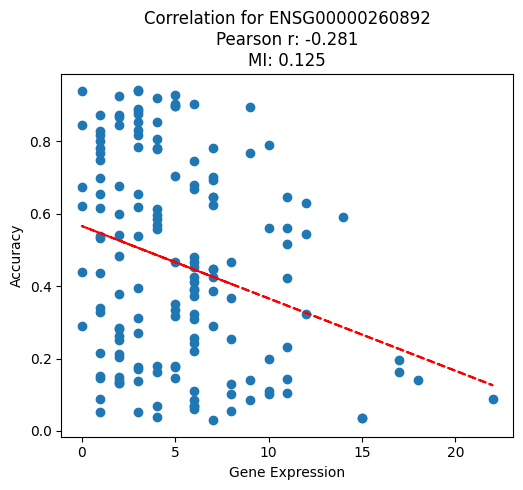

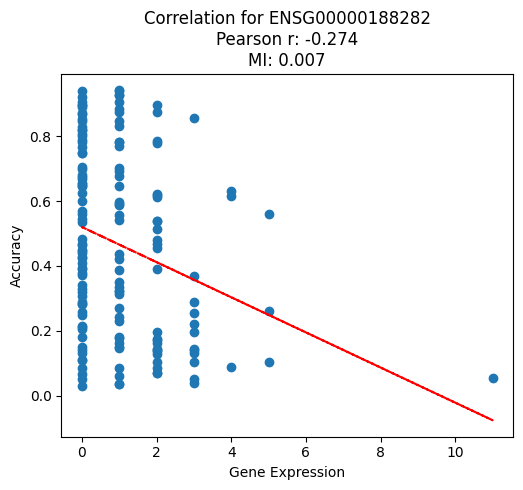

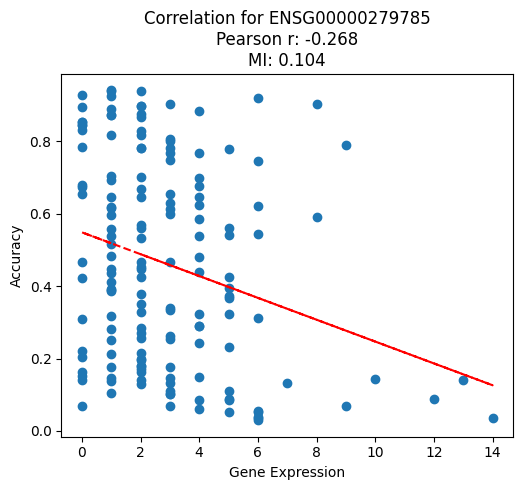

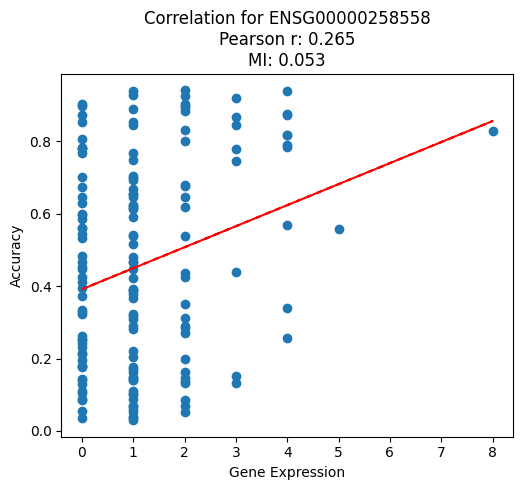

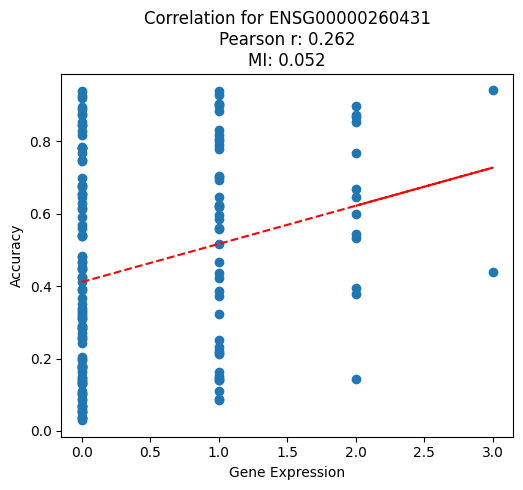

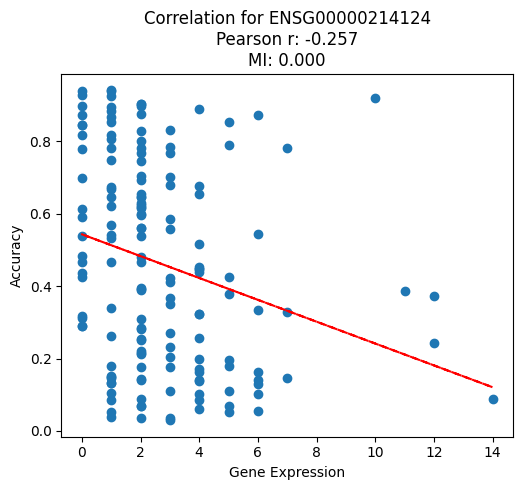

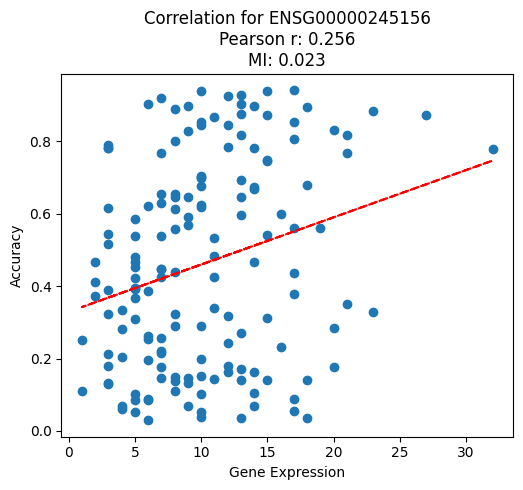

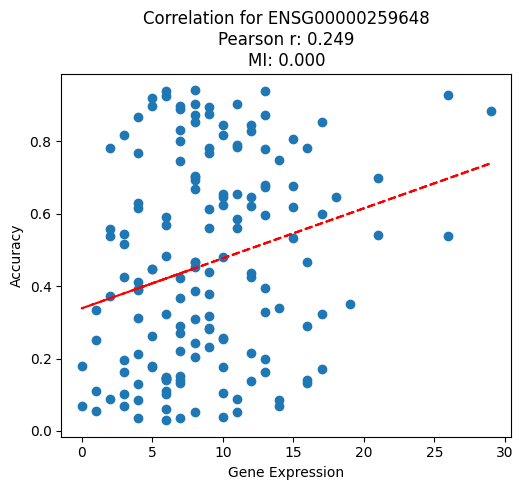

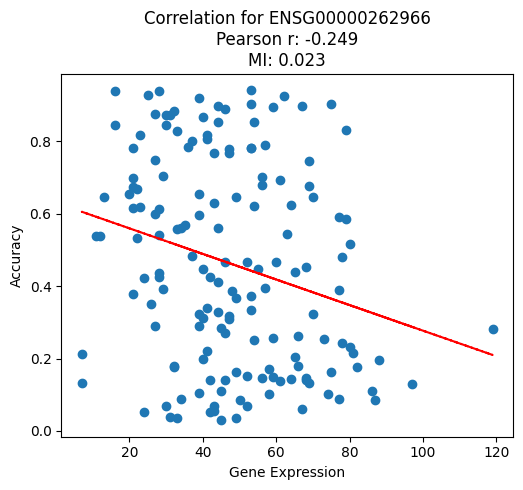

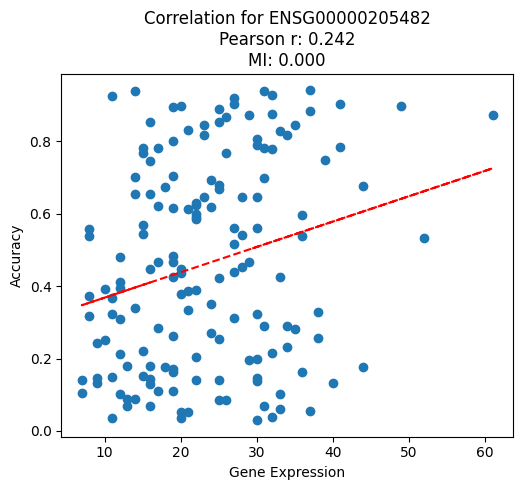

In [ ]:
for gene in correlation_results.head(10)['gene']:
    gene_expr = deg_expression.loc[gene]
    linear_corr = correlation_results.loc[correlation_results['gene'] == gene, 'linear_correlation'].values[0]
    mi = correlation_results.loc[correlation_results['gene'] == gene, 'mutual_information'].values[0]
    plot_correlation(gene_expr, accuracy_scores, gene, linear_corr, mi)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import matplotlib.pyplot as plt

def max_cca_correlation(X, y, n_components=1):
    cca = CCA(n_components=n_components)
    X_c, y_c = cca.fit_transform(X, y.reshape(-1, 1))
    return np.corrcoef(X_c.T, y_c.T)[0, 1]

def find_best_transcript_group(deg_expression, accuracy_scores, group_size, max_combinations=1000):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(deg_expression.T)
    y = accuracy_scores.values

    best_correlation = 0
    best_group = None

    for combo in combinations(range(deg_expression.shape[0]), group_size):
        if max_combinations <= 0:
            break
        X_group = X_scaled[:, combo]
        correlation = max_cca_correlation(X_group, y)

        if correlation > best_correlation:
            best_correlation = correlation
            best_group = combo

        max_combinations -= 1

    return best_correlation, [deg_expression.index[i] for i in best_group]

def infer_optimal_group_size(deg_expression, accuracy_scores, max_group_size=20, threshold=0.00001):
    results = []
    prev_correlation = 0

    for size in range(1, max_group_size + 1):
        correlation, group = find_best_transcript_group(deg_expression, accuracy_scores, size)
        improvement = correlation - prev_correlation

        results.append({
            'group_size': size,
            'max_correlation': correlation,
            'improvement': improvement,
            'transcripts': group
        })

        if size > 1 and improvement < threshold:
            break

        prev_correlation = correlation

    return pd.DataFrame(results)

   group_size  max_correlation   improvement  \
0           1         0.228499  2.284989e-01   
1           2         0.265752  3.725286e-02   
2           3         0.289338  2.358640e-02   
3           4         0.307340  1.800229e-02   
4           5         0.307801  4.605724e-04   
5           6         0.310965  3.163486e-03   
6           7         0.316748  5.783582e-03   
7           8         0.342416  2.566769e-02   
8           9         0.342416  2.679098e-09   

                                         transcripts  
0                                  [ENSG00000203392]  
1                 [ENSG00000109758, ENSG00000215374]  
2  [ENSG00000109758, ENSG00000183018, ENSG0000021...  
3  [ENSG00000109758, ENSG00000183018, ENSG0000017...  
4  [ENSG00000109758, ENSG00000183018, ENSG0000017...  
5  [ENSG00000109758, ENSG00000183018, ENSG0000017...  
6  [ENSG00000109758, ENSG00000183018, ENSG0000017...  
7  [ENSG00000109758, ENSG00000183018, ENSG0000017...  
8  [ENSG00000109758, ENS

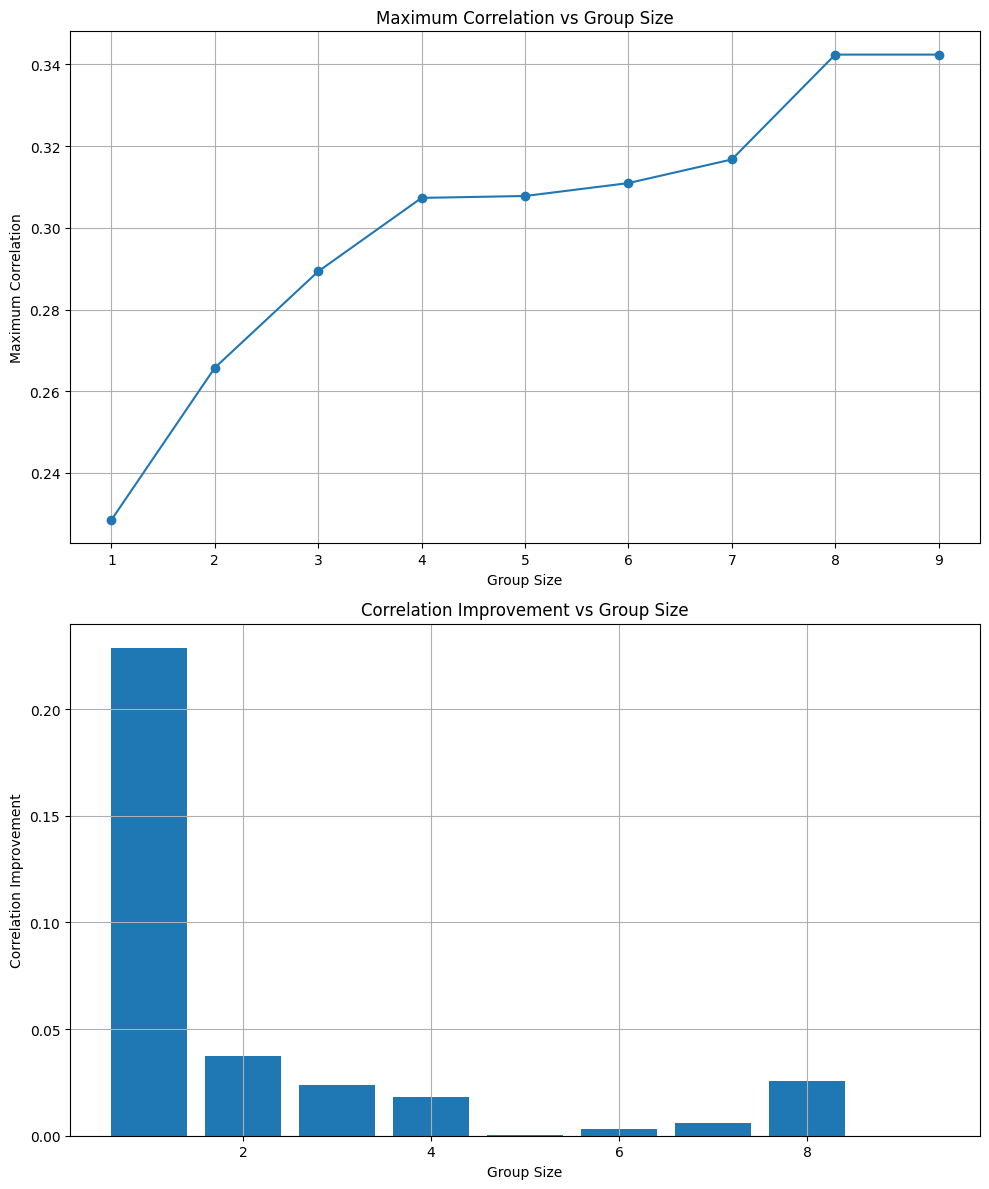

Optimal group size: 9
Optimal transcript group:
['ENSG00000109758', 'ENSG00000183018', 'ENSG00000171847', 'ENSG00000146409', 'ENSG00000198237', 'ENSG00000169249', 'ENSG00000205126', 'ENSG00000262879', 'ENSG00000203392']


In [ ]:
results_df = infer_optimal_group_size(deg_expression, accuracy_scores)
print(results_df)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Correlation plot
ax1.plot(results_df['group_size'], results_df['max_correlation'], marker='o')
ax1.set_xlabel('Group Size')
ax1.set_ylabel('Maximum Correlation')
ax1.set_title('Maximum Correlation vs Group Size')
ax1.grid(True)

# Improvement plot
ax2.bar(results_df['group_size'], results_df['improvement'])
ax2.set_xlabel('Group Size')
ax2.set_ylabel('Correlation Improvement')
ax2.set_title('Correlation Improvement vs Group Size')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print optimal group size
optimal_size = results_df.iloc[-1]['group_size']
optimal_transcripts = results_df.iloc[-1]['transcripts']
print(f"Optimal group size: {optimal_size}")
print("Optimal transcript group:")
print(optimal_transcripts)

# Case/control classifier across all normalized RNA counts

In [218]:
case_cols = [col for col in rnaMatrix.columns if 'CASE' in col]

cases = pd.concat([rnaMatrix[case_cols]], axis=1) # common_case_cols for WGS-overlapping samples
combined_data = pd.concat([cases, rnaMatrix__controls], axis=1)
condition1, condition2 = setType.split('Vs')
conditionCols = [condition1] * len(cases.columns) + [condition2] * len(rnaMatrix__controls.columns)
idCols = [extract_id(col) for col in combined_data.columns]
selected_clinical_data = clinical_data[
        clinical_data['ExternalSubjectId'].isin(idCols)
    ].set_index('ExternalSubjectId').loc[
        [col for col in idCols 
            if col in clinical_data['ExternalSubjectId'].tolist()]]
    
sample_info = pd.DataFrame({
    'sample': combined_data.columns,
    'condition': conditionCols,
    'sex genotype': [selected_clinical_data.loc[id, 'Sex Genotype'] if id in selected_clinical_data.index else None for id in idCols],
}).set_index('sample')

# drop samples missing sex genotype
sample_info = sample_info[~sample_info['sex genotype'].isna()]
combined_data = combined_data[sample_info.index]

# Create DeseqDataSet object
dds = DeseqDataSet(
    counts=combined_data.T,
    metadata=sample_info,
    design_factors=["condition"],
    ref_level=("condition", condition2)  # Set the reference level to condition2
)

dds.fit_size_factors()
normalized_counts = dds.layers["normed_counts"]
dds


Fitting size factors...
... done in 0.39 seconds.



AnnData object with n_obs × n_vars = 509 × 60664
    obs: 'condition', 'sex genotype'
    obsm: 'design_matrix', 'size_factors'
    varm: '_normed_means'
    layers: 'normed_counts'

Original data shape: (509, 60664)
Data shape after removing invariant features: (509, 57595)
Removed 3069 invariant features
Class distribution:
 condition
AllCases    0.895874
AllCtrl     0.104126
Name: proportion, dtype: float64
Sex genotype distribution:
 sex_genotype
XY                                                                                                           0.589391
XX                                                                                                           0.398821
ExternalSubjectId
NEUAY067UTB    XX
NEUAY067UTB    XX
Name: Sex Genotype, dtype: object                      0.001965
ExternalSubjectId
NEUGW340YEB    XX
NEUGW340YEB    XX
Name: Sex Genotype, dtype: object                      0.001965
ExternalSubjectId
NEUJY536DKF    XO/XY
NEUJY536DKF    XO/XY
Name: Sex Genotype, dtype: object                0.001965
ExternalSubjectId
NEUVX902YNL     XY
NEUVX902YNL    NaN
Name: Sex Genotype, dtype: object                    0.001965
ExternalSubjectId
NE

/Users/noot/.pyenv/versions/miniconda3-latest/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/noot/.pyenv/versions/miniconda3-latest/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

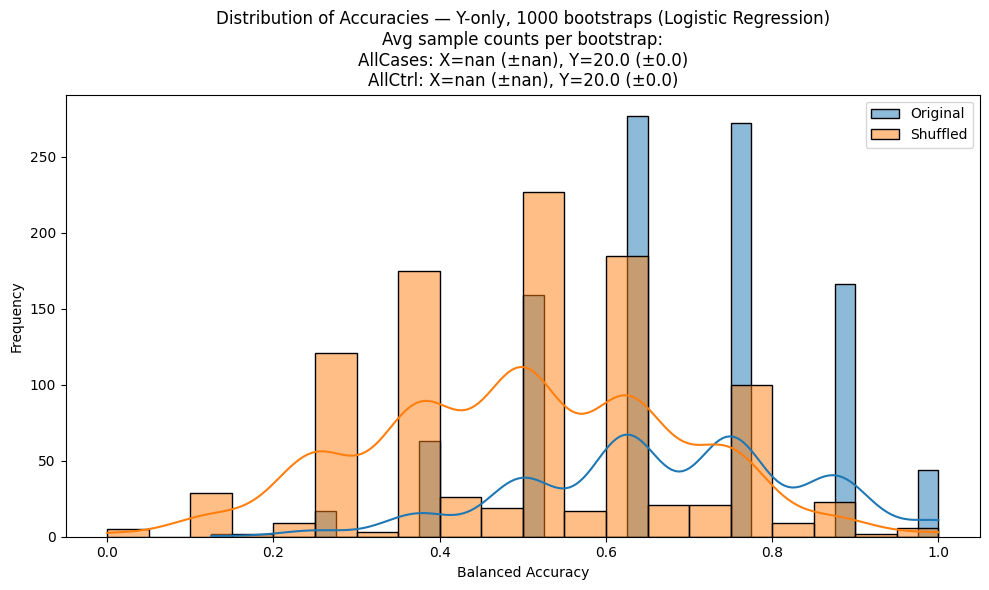


Original - Mean Balanced Accuracy: 0.6740 (±0.1665)
Shuffled - Mean Balanced Accuracy: 0.5021 (±0.1841)


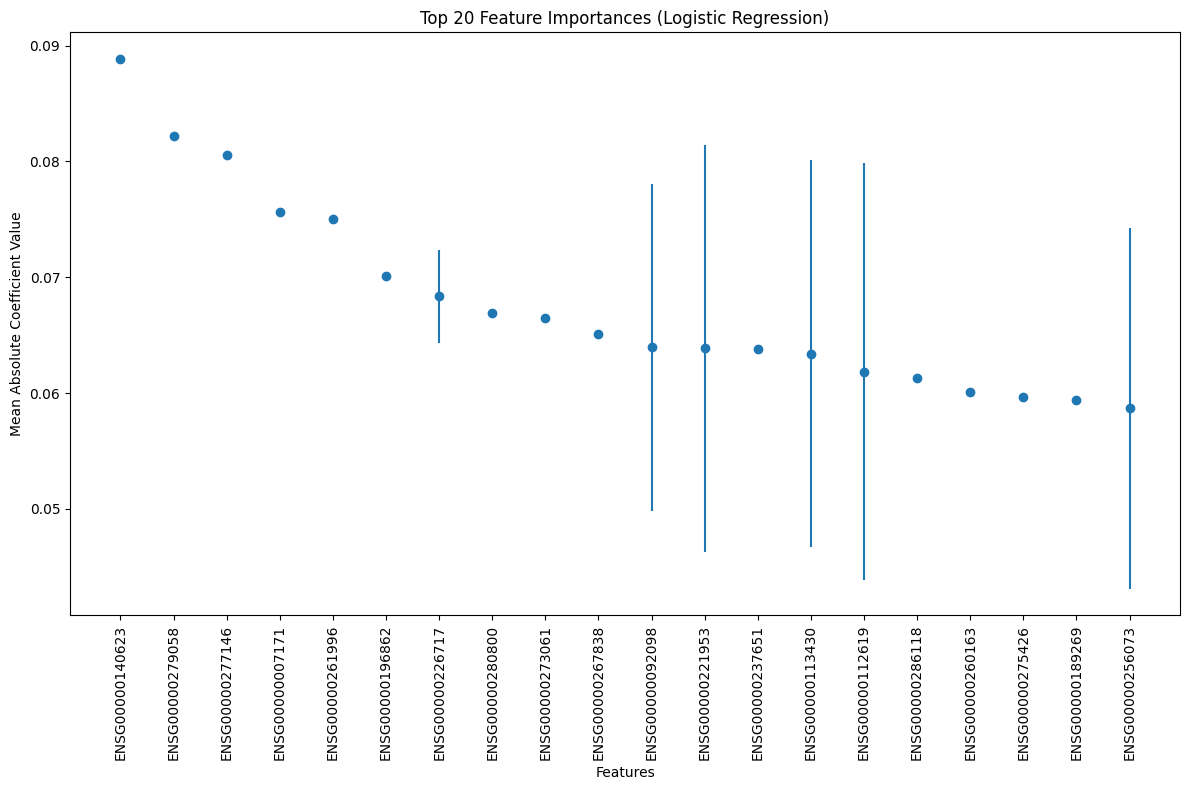


Top 20 Features:
                         Feature  Importance       Std
Geneid                                                
ENSG00000140623  ENSG00000140623    0.088866       NaN
ENSG00000279058  ENSG00000279058    0.082226       NaN
ENSG00000277146  ENSG00000277146    0.080521       NaN
ENSG00000007171  ENSG00000007171    0.075642       NaN
ENSG00000261996  ENSG00000261996    0.074997       NaN
ENSG00000196862  ENSG00000196862    0.070145       NaN
ENSG00000226717  ENSG00000226717    0.068367  0.004001
ENSG00000280800  ENSG00000280800    0.066920       NaN
ENSG00000273061  ENSG00000273061    0.066460       NaN
ENSG00000267838  ENSG00000267838    0.065107       NaN
ENSG00000092098  ENSG00000092098    0.063938  0.014082
ENSG00000221953  ENSG00000221953    0.063854  0.017607
ENSG00000237651  ENSG00000237651    0.063824       NaN
ENSG00000113430  ENSG00000113430    0.063414  0.016709
ENSG00000112619  ENSG00000112619    0.061860  0.017973
ENSG00000286118  ENSG00000286118    0.061299   

KeyboardInterrupt: 

In [248]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm

def preprocess_data(dds):
    normalized_counts = dds.layers['normed_counts']
    df = pd.DataFrame(normalized_counts, columns=dds.var_names, index=dds.obs_names)
    df['condition'] = dds.obs['condition']
    df['sex_genotype'] = dds.obs['sex genotype']
    return df

def remove_invariant_features(X):
    selector = VarianceThreshold(threshold=0)
    X_var = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()], index=X.index)
    return X_var

def shuffle_labels(y, sex_genotype, random_state=42):
    # np.random.seed(random_state)
    
    # Initialize a new Series to hold the shuffled labels
    shuffled_y = pd.Series(index=y.index, dtype=y.dtype)
    
    # Shuffle the labels within each sex genotype group
    for genotype in sex_genotype.unique():
        indices = sex_genotype[sex_genotype == genotype].index
        shuffled_y.loc[indices] = np.random.permutation(y.loc[indices].values)
    
    return shuffled_y

def calculate_avg_counts_per_condition(stratified_counts_list):
    avg_counts_per_condition = {}
    
    # Parse the stratification counts to sum X and Y per condition
    for stratification_counts in stratified_counts_list:
        for strat, count in stratification_counts.items():
            condition, sex = strat.split('_')
            if condition not in avg_counts_per_condition:
                avg_counts_per_condition[condition] = {'X': [], 'Y': []}
            avg_counts_per_condition[condition][sex].append(count)
    
    # Calculate average and std deviation for X and Y in each condition
    for condition, counts in avg_counts_per_condition.items():
        for sex in ['X', 'Y']:
            avg_counts_per_condition[condition][sex] = {
                'mean': np.mean(counts[sex]),
                'std': np.std(counts[sex])
            }
    
    return avg_counts_per_condition

def stratified_group_sample(X, y, sex_genotype, size):
    # Group Y-chromosome individuals together
    sex_genotype_grouped = sex_genotype.apply(lambda x: 'Y' if 'Y' in x else 'X')

    # Create strata based on condition and sex genotype grouping
    strata = y.astype(str) + '_' + sex_genotype_grouped.astype(str)
    unique_strata = strata.unique()
    sampled_indices = []
    
    # Calculate the minimum size of any stratum
    min_stratum_size = min(len(strata[strata == stratum]) for stratum in unique_strata)
    
    for stratum in unique_strata:
        stratum_indices = strata[strata == stratum].index
        # Use min_stratum_size to ensure balanced sampling
        n_samples = min(min_stratum_size, int(size / len(unique_strata)))
        sampled_indices.extend(np.random.choice(stratum_indices, size=n_samples, replace=True))
    
    return sampled_indices

def single_bootstrap(X, y, sex_genotype, model_class, test_size=0.2, random_state=42, shuffle_test=False, isolate_sex_genotype='Y'):
    # np.random.seed(random_state)
    
    # Group Y-chromosome individuals together
    sex_genotype_grouped = sex_genotype.apply(lambda x: 'Y' if 'Y' in x else 'X')

    # Optionally isolate sex genotype cohort (Y-only or X-only)
    if isolate_sex_genotype is not None:
        if isolate_sex_genotype not in ['X', 'Y']:
            raise ValueError("isolate_sex_genotype must be either 'X' or 'Y'")
        isolation_indices = sex_genotype_grouped[sex_genotype_grouped == isolate_sex_genotype].index
        X = X.loc[isolation_indices]
        y = y.loc[isolation_indices]
        sex_genotype_grouped = sex_genotype_grouped.loc[isolation_indices]

    # Stratified sampling with replacement
    boot_idx = stratified_group_sample(X, y, sex_genotype_grouped, size=len(X))
    X_boot, y_boot, sex_boot = X.loc[boot_idx], y.loc[boot_idx], sex_genotype_grouped.loc[boot_idx]

    # Create stratification column for train/test split
    stratification = y_boot.astype(str) + '_' + sex_boot.astype(str)
    
    # Record sample counts for the bootstrapped sample
    stratified_counts = stratification.value_counts().to_dict()
    
    # Stratified train/test split
    X_train, X_test, y_train, y_test, sex_train, sex_test = train_test_split(
        X_boot, y_boot, sex_boot, test_size=test_size, stratify=stratification,
        random_state=random_state
    )
    
    # Feature selection using SelectFromModel
    if model_class in [SVC]:
        selector = SelectFromModel(Lasso(alpha=0.01, random_state=random_state), max_features=None, threshold="mean")
    else:
        selector = SelectFromModel(model_class(random_state=random_state), max_features=None, threshold="mean")
    
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    selected_features = X_train.columns[selector.get_support()]

    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_selected), columns=selected_features, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_selected), columns=selected_features, index=X_test.index)

    model = model_class(random_state=random_state)
    model.fit(X_train_scaled, y_train)

    if shuffle_test:
        y_test = shuffle_labels(y_test, sex_test, random_state=random_state) # shuffle_labels(y_test, sex_test, random_state=random_state)

    y_pred = model.predict(X_test_scaled)

    accuracy = balanced_accuracy_score(y_test, y_pred)
    
    if hasattr(model, 'coef_'):
        feature_importances = pd.Series(np.abs(model.coef_[0]), index=selected_features)
    elif hasattr(model, 'feature_importances_'):
        feature_importances = pd.Series(model.feature_importances_, index=selected_features)
    else:
        feature_importances = pd.Series(0, index=selected_features)
    
    return accuracy, feature_importances, len(selected_features), stratified_counts


def bootstrap_evaluate(X, y, sex_genotype, model_class, n_bootstraps=200, test_size=0.2, random_state=42, shuffle_test=False, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(single_bootstrap)(X, y, sex_genotype, model_class, test_size, random_state + i, shuffle_test)
        for i in tqdm(range(n_bootstraps))
    )
    
    accuracies, feature_importances_list, n_features_selected, stratified_counts_list = zip(*results)
    return list(accuracies), list(feature_importances_list), list(n_features_selected), list(stratified_counts_list)


def plot_results(original_accuracies, shuffled_accuracies, stratified_counts_list, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(original_accuracies, kde=True, label='Original')
    sns.histplot(shuffled_accuracies, kde=True, label='Shuffled')

    # Calculate average counts per condition
    avg_counts_per_condition = calculate_avg_counts_per_condition(stratified_counts_list)
    
    # Add average X and Y counts per condition to the title
    count_strings = []
    for condition, counts in avg_counts_per_condition.items():
        count_string = f"{condition}: X={counts['X']['mean']:.1f} (±{counts['X']['std']:.1f}), Y={counts['Y']['mean']:.1f} (±{counts['Y']['std']:.1f})"
        count_strings.append(count_string)
    
    # Update the title with average counts
    detailed_title = f"{title}\nAvg sample counts per bootstrap:\n" + "\n".join(count_strings)
    
    plt.title(detailed_title)
    plt.xlabel('Balanced Accuracy')
    plt.ylabel('Frequency')

    # Set x-axis ticks at every 10%
    # plt.xticks(np.arange(0, 1.1, 0.1))
    
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"\nOriginal - Mean Balanced Accuracy: {np.mean(original_accuracies):.4f} (±{np.std(original_accuracies):.4f})")
    print(f"Shuffled - Mean Balanced Accuracy: {np.mean(shuffled_accuracies):.4f} (±{np.std(shuffled_accuracies):.4f})")

    
def plot_feature_importances(feature_importances_list, title):
    all_features = pd.concat(feature_importances_list, axis=1).abs()
    mean_importances = all_features.mean(axis=1)
    std_importances = all_features.std(axis=1)

    top_features = pd.DataFrame({
        'Feature': mean_importances.index,
        'Importance': mean_importances,
        'Std': std_importances
    }).sort_values('Importance', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    plt.errorbar(range(20), top_features['Importance'], yerr=top_features['Std'], fmt='o')
    plt.xticks(range(20), top_features['Feature'], rotation=90)
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Mean Absolute Coefficient Value')
    plt.tight_layout()
    plt.show()

    print("\nTop 20 Features:")
    print(top_features)

# Main execution
df = preprocess_data(dds)

X = df.drop(['condition', 'sex_genotype'], axis=1)
y = df['condition']
sex_genotype = df['sex_genotype']

print("Original data shape:", X.shape)

X_var = remove_invariant_features(X)
print("Data shape after removing invariant features:", X_var.shape)
print(f"Removed {X.shape[1] - X_var.shape[1]} invariant features")

print("Class distribution:\n", y.value_counts(normalize=True))
print("Sex genotype distribution:\n", sex_genotype.value_counts(normalize=True))

fixed_random_state = 42

models = {
    "Logistic Regression": LogisticRegression,
    #"Decision Tree": DecisionTreeClassifier,
    "Random Forest": RandomForestClassifier,
    # "SVM": SVC
}

for model_name, model_class in models.items():
    print(f"\nRunning {model_name}...")
    original_accuracies, original_importances, n_features, stratified_counts_list = bootstrap_evaluate(X_var, y, sex_genotype, model_class, random_state=fixed_random_state, n_bootstraps=1000, shuffle_test=False)
    shuffled_accuracies, _, _, _ = bootstrap_evaluate(X_var, y, sex_genotype, model_class, random_state=fixed_random_state, n_bootstraps=1000, shuffle_test=True)
    
    plot_results(original_accuracies, shuffled_accuracies, stratified_counts_list, f'Distribution of Accuracies — Y-only, 1000 bootstraps ({model_name})')
    if model_name != "SVM":  # SVM doesn't have built-in feature importances
        plot_feature_importances(original_importances, f'Top 20 Feature Importances ({model_name})')
    
    print(f"Average number of features selected: {np.mean(n_features):.2f} (±{np.std(n_features):.2f})")

# Sample accuracy tails

# Map DEG ids to symbols for GSEA & GOrilla

In [ ]:
# Add gene symbols, biotypes, and synonyms to your results
currentSignificantDegs = degResultsDict['WellPredCaseVsAllCtrl']['significant_degs']
currentSignificantDegs['gene_symbol'] = currentSignificantDegs.index.map(lambda x: id_map.get(x, {}).get('symbol', ''))
currentSignificantDegs['gene_biotype'] = currentSignificantDegs.index.map(lambda x: id_map.get(x, {}).get('biotype', ''))
currentSignificantDegs['gene_synonyms'] = currentSignificantDegs.index.map(lambda x: ', '.join(id_map.get(x, {}).get('synonyms', set())))

<ipython-input-67-a0acca074feb>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-67-a0acca074feb>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-67-a0acca074feb>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Create a ranked list for GSEA
# Create a composite score
results_df = degResultsDict['WellPredCaseVsAllCtrl']['results_df']
composite_score = results_df['log2FoldChange'] / (results_df['padj'] + 1e-12)
ranked_genes = composite_score.sort_values(ascending=False)

# Map to gene symbols, remove unmapped and NA, and convert to uppercase
ranked_genes.index = ranked_genes.index.map(lambda x: id_map.get(x, {}).get('symbol', x))
ranked_genes = ranked_genes[ranked_genes.index != ''].dropna()
ranked_genes.index = ranked_genes.index.str.upper()

# Save the ranked list
ranked_genes.to_csv('ranked_genes_for_gsea__WellPredCaseVsAllCtrl.rnk', sep='\t', header=False)

In [145]:
ranked_genes

NameError: name 'ranked_genes' is not defined

In [ ]:
%pip install gseapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.9/552.9 kB 5.2 MB/s eta 0:00:00


In [ ]:
from zipfile import ZipFile

msigZip_path = '/content/drive/MyDrive/ALS genomics/Transcriptomics/msigdb_v2023.2.Hs.zip'

with ZipFile(msigZip_path, 'r') as zObject:
	zObject.extractall()


In [ ]:
import os
gmtDir = '/content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs'
gmtPaths = [
    os.path.join(gmtDir, gmt) for gmt in os.listdir(gmtDir)
  if gmt.endswith('symbols.gmt')
    and (gmt.startswith('h.')
    or gmt.startswith('c1.')
    or gmt.startswith('c2.')
    or gmt.startswith('c3.')
    )]

In [ ]:
def rename_gmt_files(file_paths):
    new_paths = []
    for path in file_paths:
        # Split the path into directory and filename
        directory, filename = os.path.split(path)

        # Split the filename into parts
        parts = filename.split('.')

        # Keep the extension and the second-to-last part (symbols or entrez) as is
        extension = parts[-1]
        identifier = parts[-2]

        # Join the rest of the parts with underscores
        new_name = '_'.join(parts[:-2]) + f'.{identifier}.{extension}'

        # Create the new path
        new_path = os.path.join(directory, new_name)

        # Rename the file
        os.rename(path, new_path)

        new_paths.append(new_path)

        print(f"Renamed: {path} -> {new_path}")

    return new_paths

# Rename the files
gmtPaths = rename_gmt_files(gmtPaths)

Renamed: /content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c2.cp.kegg_medicus.v2023.2.Hs.symbols.gmt -> /content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c2_cp_kegg_medicus_v2023_2_Hs.symbols.gmt
Renamed: /content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c3.mir.v2023.2.Hs.symbols.gmt -> /content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c3_mir_v2023_2_Hs.symbols.gmt
Renamed: /content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c2.cp.reactome.v2023.2.Hs.symbols.gmt -> /content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c2_cp_reactome_v2023_2_Hs.symbols.gmt
Renamed: /content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c1.all.v2023.2.Hs.symbols.gmt -> /content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c1_all_v2023_2_Hs.symbols.gmt
Renamed: /content/msigdb_v2023.2.Hs_files_to_download_locally/ms

In [ ]:
gmtPaths

['/content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c2_cp_kegg_medicus_v2023_2_Hs.symbols.gmt',
 '/content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c3_mir_v2023_2_Hs.symbols.gmt',
 '/content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c2_cp_reactome_v2023_2_Hs.symbols.gmt',
 '/content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c1_all_v2023_2_Hs.symbols.gmt',
 '/content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c3_tft_gtrd_v2023_2_Hs.symbols.gmt',
 '/content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c2_all_v2023_2_Hs.symbols.gmt',
 '/content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c3_all_v2023_2_Hs.symbols.gmt',
 '/content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c2_cp_kegg_legacy_v2023_2_Hs.symbols.gmt',
 '/content/msigdb_v2023.2.Hs_files_to_download_locally/msigdb_v2023.2.Hs_GMTs/c2_cp_

In [ ]:
working_dir = "/content/drive/MyDrive/ALS genomics/Transcriptomics/"
outdir = f'{working_dir}gsea_output_WellPredCaseVsAllCtrl'

In [ ]:
import gseapy as gp
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import gc

def run_gsea_single(ranked_genes, gmt_path, **kwargs):
    gs_name = os.path.basename(gmt_path).split('.')[0]
    outdir = os.path.join(kwargs['outdir'], gs_name)
    os.makedirs(outdir, exist_ok=True)
    single_kwargs = {**kwargs, 'outdir': outdir}
    gs_res = gp.prerank(rnk=ranked_genes, gene_sets=gmt_path, **single_kwargs)
    result = gs_res.res2d
    del gs_res
    gc.collect()
    return result

def run_gsea_for_all_gene_sets(ranked_genes, gmt_paths, **kwargs):
    results = []
    for gmt_path in tqdm(gmt_paths):
        result = run_gsea_single(ranked_genes, gmt_path, **kwargs)
        results.append(result)
        gc.collect()

    print("Combining results...")
    combined_res2d = pd.concat(results)
    del results
    gc.collect()

    print("Done.")
    return combined_res2d

gc.collect()

# Run GSEA for all gene sets
gsea_results = run_gsea_for_all_gene_sets(
    ranked_genes,
    missingGMTpaths[2:3],
    outdir=outdir,
    permutation_num=1000,
    min_size=3,
    max_size=1000,
    seed=42  # Use a consistent seed for reproducibility
)

NameError: name 'missingGMTpaths' is not defined

In [ ]:
gseaResults_files = os.listdir(outdir)
results_fileName = 'gseapy.gene_set.prerank.report.csv'
gseaResults_files

['c1_all_v2023_2_Hs',
 'c2_cgp_v2023_2_Hs',
 'c3_mir_mirdb_v2023_2_Hs',
 'c2_cp_wikipathways_v2023_2_Hs',
 'c2_cp_pid_v2023_2_Hs',
 'c3_tft_gtrd_v2023_2_Hs',
 'c3_all_v2023_2_Hs',
 'c3_tft_v2023_2_Hs',
 'c3_mir_mir_legacy_v2023_2_Hs',
 'h_all_v2023_2_Hs',
 'c2_cp_kegg_legacy_v2023_2_Hs',
 'c2_cp_reactome_v2023_2_Hs',
 'c3_tft_tft_legacy_v2023_2_Hs',
 'c2_cp_kegg_medicus_v2023_2_Hs',
 'c2_all_v2023_2_Hs',
 'c2_cp_biocarta_v2023_2_Hs',
 'c2_cp_v2023_2_Hs',
 'c3_mir_v2023_2_Hs',
 'combined_gsea_results.csv']

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy import stats

def load_and_combine_results(outdir, gseaResults_files, results_fileName):
    all_results = []
    for folder in tqdm(gseaResults_files):
        file_path = os.path.join(outdir, folder, results_fileName)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df['Gene_set'] = folder  # Add a column to identify the gene set
            all_results.append(df)

    combined_results = pd.concat(all_results, ignore_index=True)
    return combined_results

def calculate_global_statistics(combined_results, permutation_num=1000, seed=42):
    np.random.seed(seed)

    es_values = combined_results['ES'].values

    # Extract gene set sizes from 'Tag %' column
    gene_set_sizes = combined_results['Tag %'].apply(lambda x: int(x.split('/')[1])).values

    # Calculate NES
    pos_es = es_values[es_values > 0]
    neg_es = es_values[es_values < 0]
    pos_mean = np.mean(pos_es) if len(pos_es) > 0 else 1
    neg_mean = np.mean(np.abs(neg_es)) if len(neg_es) > 0 else 1
    nes_values = np.where(es_values >= 0, es_values / pos_mean, es_values / neg_mean)

    # Calculate nominal p-values
    null_es = np.random.normal(0, 1, (len(es_values), permutation_num))
    pvals = np.mean(np.abs(null_es) >= np.abs(es_values)[:, np.newaxis], axis=1)

    # Calculate FDR
    fdr = calculate_gsea_fdr(es_values, nes_values, gene_set_sizes, permutation_num)

    # Update combined_results
    combined_results['NES'] = nes_values
    combined_results['NOM p-val'] = pvals
    combined_results['FDR q-val'] = fdr

    return combined_results

def calculate_gsea_fdr(es_values, nes_values, gene_set_sizes, num_permutations=1000):
    def create_null_distribution(values, sizes, n_perm):
        null_dist = []
        for _ in range(n_perm):
            perm_es = np.random.choice(values, size=len(values), replace=True)
            perm_nes = perm_es / np.mean(np.abs(perm_es))
            null_dist.extend(perm_nes)
        return np.array(null_dist)

    def calculate_fdr_one_sided(observed_nes, null_nes):
        total_observed = len(observed_nes)
        total_null = len(null_nes)

        observed_hits = np.array([np.sum(np.abs(null_nes) >= np.abs(nes)) for nes in observed_nes])
        null_hits = np.array([np.sum(np.abs(observed_nes) >= np.abs(nes)) for nes in null_nes])

        fdr = (observed_hits / total_null) / (null_hits / total_observed)
        fdr = np.minimum.accumulate(fdr)  # Ensure monotonicity
        return fdr

    pos_mask = nes_values > 0
    neg_mask = nes_values < 0

    null_nes = create_null_distribution(es_values, gene_set_sizes, num_permutations)

    fdr_pos = calculate_fdr_one_sided(nes_values[pos_mask], null_nes[null_nes > 0])
    fdr_neg = calculate_fdr_one_sided(-nes_values[neg_mask], -null_nes[null_nes < 0])

    fdr = np.empty_like(nes_values)
    fdr[pos_mask] = fdr_pos
    fdr[neg_mask] = fdr_neg

    return fdr

# Load and combine all results
combined_results = load_and_combine_results(outdir, gseaResults_files, results_fileName)

# Recalculate global statistics
final_results = calculate_global_statistics(combined_results)

# Sort results by FDR q-val (ascending) and absolute value of NES (descending)
final_results_sorted = final_results.sort_values(
    by=['FDR q-val', 'NES'],
    key=lambda x: x if x.name != 'NES' else x.abs(),
    ascending=[True, False]
)

# Save the combined and recalculated results
final_results_sorted.to_csv(os.path.join(outdir, 'combined_gsea_results.csv'), index=False)

# Print summary statistics
print(f"Total number of gene sets analyzed: {len(final_results_sorted)}")
print("\nTop 10 enriched gene sets across all collections:")
print(final_results_sorted[['Gene_set', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'Tag %', 'Gene %']].head(10))

# Optional: Print top genes for the most significant gene sets
print("\nTop genes for the most significant gene sets:")
for _, row in final_results_sorted.head(5).iterrows():
    top_genes = row['Lead_genes'].split(';')[:5]  # Assuming 'Lead_genes' contains gene names
    print(f"{row['Gene_set']} - {row['Term']}: {', '.join(top_genes)}")

NameError: name 'outdir' is not defined

In [ ]:
final_results_sorted.head(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,Gene_set
7487,prerank,AGGAGTG_MIR483,-0.998125,-1.537153,0.138,0.106,0.333,1/65,0.01%,USP6,c3_all_v2023_2_Hs
12117,prerank,AGGAGTG_MIR483,-0.998125,-1.537153,0.120,0.106,0.031,1/65,0.01%,USP6,c3_mir_mir_legacy_v2023_2_Hs
19543,prerank,AGGAGTG_MIR483,-0.998125,-1.537153,0.119,0.106,0.294,1/65,0.01%,USP6,c3_mir_v2023_2_Hs
3709,prerank,MIR4520_3P,-0.997400,-1.536037,0.125,0.106,0.376,1/81,0.01%,USP6,c3_mir_mirdb_v2023_2_Hs
7489,prerank,MIR4520_3P,-0.997400,-1.536037,0.108,0.106,0.433,1/81,0.01%,USP6,c3_all_v2023_2_Hs
19545,prerank,MIR4520_3P,-0.997400,-1.536037,0.137,0.106,0.386,1/81,0.01%,USP6,c3_mir_v2023_2_Hs
12579,prerank,REACTOME_RUNX3_REGULATES_IMMUNE_RESPONSE_AND_C...,-0.996456,-1.534582,0.124,0.106,0.998,1/6,0.11%,ITGA4,c2_cp_reactome_v2023_2_Hs
15791,prerank,REACTOME_RUNX3_REGULATES_IMMUNE_RESPONSE_AND_C...,-0.996456,-1.534582,0.133,0.106,1.000,1/6,0.11%,ITGA4,c2_cp_v2023_2_Hs
3708,prerank,MIR3126_3P,-0.996147,-1.534106,0.146,0.106,0.372,1/41,0.01%,USP6,c3_mir_mirdb_v2023_2_Hs
7488,prerank,MIR3126_3P,-0.996147,-1.534106,0.117,0.106,0.428,1/41,0.01%,USP6,c3_all_v2023_2_Hs


In [ ]:
degResultsDict['AllCasesVsAllCtrl']['combined_data']

,CASE-NEULC153TP4-8513-T,CASE-NEUCU076ADN-7708-T,CASE-NEUYC303AJY-6997-T,CASE-NEUJG311WGV-7046-T,CASE-NEULL648LJ1-6059-T,CASE-NEUXW790VZK-8653-T,CASE-NEUCB613CA9-6487-T,CASE-NEUAW157NMJ-5550-T,CASE-NEUHB491NGF-6185-T,CASE-NEUJY426MBU-5947-T,...,CTRL-NEUJH928PGD-9376-T,CTRL-NEUMF196GPV-9474-T,CTRL-NEUMV031UD8-9586-T,CTRL-NEUNB744CAL-9383-T,CTRL-NEUNG931UCJ-9684-T,CTRL-NEUUW945MZ5-9929-T,CTRL-NEUUX563RM1-9467-T,CTRL-NEUWD043UBM-10463-T,CTRL-NEUYA376UJ4-10491-T,CTRL-NEUZW913DKF-10561-T
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,885,1237,942,796,1326,760,718,965,726,1643,...,1423,805,1217,450,970,820,1006,1402,906,1044
ENSG00000000005,2,0,11,0,1,1,2,0,0,0,...,0,0,1,0,0,0,0,5,3,0
ENSG00000000419,1794,890,1126,1202,1546,1444,1142,1099,1192,1437,...,1711,957,1231,1202,1247,1143,1206,968,844,1029
ENSG00000000457,347,608,641,792,1040,463,684,545,567,891,...,827,525,756,327,579,542,589,687,582,595
ENSG00000000460,293,210,258,273,307,205,255,240,354,433,...,370,193,236,177,210,261,223,215,193,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288721,98,56,96,62,77,57,52,73,98,85,...,112,65,63,80,79,73,71,32,50,47
ENSG00000288722,10,20,13,38,31,18,20,30,50,15,...,23,24,20,15,51,17,19,46,31,42
ENSG00000288723,8,1,5,1,5,7,4,5,4,12,...,9,2,2,2,7,2,2,2,2,4


In [ ]:
for setType in subsetComparisons:
  degResultsDict['AllCasesVsAllCtrl']['results_df'][
      degResultsDict['AllCasesVsAllCtrl']['results_df'].index.isin(nups_map_df['ensembl_id'])
  ].to_csv(f"{working_dir}aalsNUPs{setType}__pydeseq2_randomBalanced.csv")

In [ ]:
nups_map_df.index

RangeIndex(start=0, stop=63, step=1)